#### Benchmark

Tried to build it according to the description from the challenge page.

In [1]:
import json

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')


In [2]:
path = "files/"

train = pd.read_csv(path + "X_train.csv")
test = pd.read_csv(path + "X_test.csv")
y = pd.read_csv(path + "y_train.csv")

train = pd.merge(train, y, left_on="obs_id", right_on="obs_id")

# train["venue_cat"] = pd.Categorical(train["venue"]).codes
train["action_cat"] = pd.Categorical(train["action"]).codes
# train["trade_cat"] = pd.Categorical(train["trade"]).codes

test["action_cat"] = pd.Categorical(test["action"]).codes

In [3]:
train.eqt_code_cat.value_counts() / len(train)

eqt_code_cat
10    0.041667
15    0.041667
6     0.041667
2     0.041667
3     0.041667
22    0.041667
17    0.041667
20    0.041667
21    0.041667
9     0.041667
8     0.041667
4     0.041667
5     0.041667
12    0.041667
14    0.041667
16    0.041667
18    0.041667
19    0.041667
23    0.041667
7     0.041667
11    0.041667
13    0.041667
0     0.041667
1     0.041667
Name: count, dtype: float64

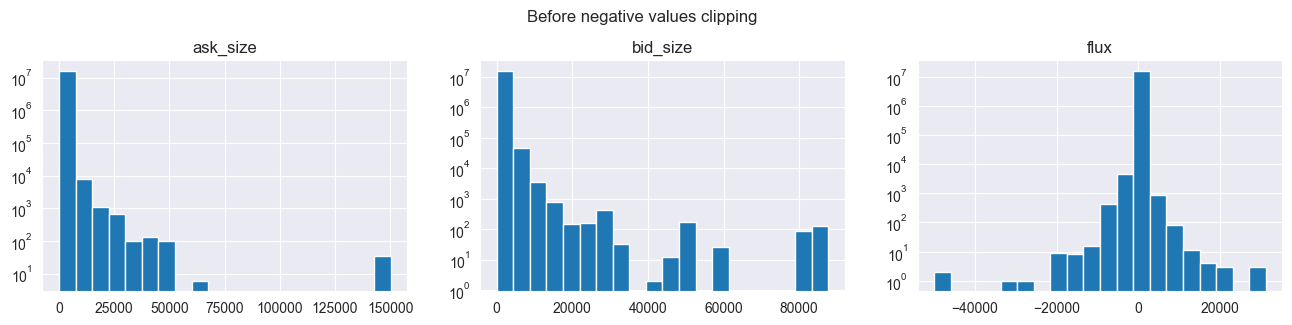

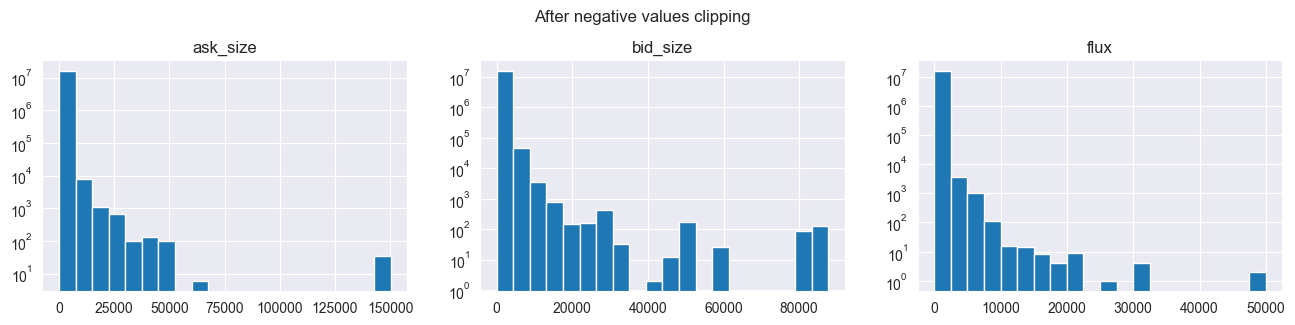

In [4]:
plt.figure(figsize=(16, 3))
for i, col in enumerate(["ask_size", "bid_size", "flux"]):
    plt.subplot(1, 3, i + 1)
    plt.hist(train[col], bins=20)
    plt.yscale("log")
    plt.title(col)
plt.suptitle("Before negative values clipping", y=1.05)
plt.show()

train.ask_size = train.ask_size.clip(lower=0)
train.bid_size = train.bid_size.clip(lower=0)
train.flux = train.flux.abs()

plt.figure(figsize=(16, 3))
for i, col in enumerate(["ask_size", "bid_size", "flux"]):
    plt.subplot(1, 3, i + 1)
    plt.hist(train[col], bins=20)
    plt.yscale("log")
    plt.title(col)
plt.suptitle("After negative values clipping", y=1.05)
plt.show()

In [5]:
train.groupby("obs_id").get_group(0)

obs_id  venue  order_id action side  price  bid   ask  bid_size  ask_size  \
0        0      4         0      A    A   0.30  0.0  0.01       100         1   
1        0      4         1      A    B  -0.17  0.0  0.01       100         1   
2        0      4         2      D    A   0.28  0.0  0.01       100         1   
3        0      4         3      A    A   0.30  0.0  0.01       100         1   
4        0      4         4      D    A   0.37  0.0  0.01       100         1   
..     ...    ...       ...    ...  ...    ...  ...   ...       ...       ...   
95       0      4        62      A    A   0.38  0.0  0.02       100       310   
96       0      4        63      A    A   0.38  0.0  0.02       100       310   
97       0      4        64      A    A   0.41  0.0  0.02       100       310   
98       0      4        63      D    A   0.38  0.0  0.02       100       310   
99       0      4        65      A    A   0.44  0.0  0.02       100       310   

    trade  flux  eqt_code_cat  action_cat  
0   False   100            10           0  
1   False   100            10           0  
2   False   100            10           1  
3   False   100            10           0  
4   False   100            10           1  
..    ...   ...           ...         ...  
95  False   100            10           0  
96  False   100            10           0  
97  False   100            10           0  
98  False   100            10           1  
99  False   100            10           0  

[100 rows x 14 columns]

In [6]:
y

obs_id  eqt_code_cat
0            0            10
1            1            15
2            2             0
3            3            13
4            4             0
...        ...           ...
160795  160795            13
160796  160796             1
160797  160797             3
160798  160798            11
160799  160799             5

[160800 rows x 2 columns]

In [7]:
class StocksDataset(Dataset):
    def __init__(self, df, seq_len=100):
        super().__init__()
        
        self.seq_len = seq_len
        
        # We group by obs_id
        # (You may need to ensure there's a 'time' or 'event_index' column to sort by.)
        grouped = df.groupby("obs_id")
        
        self.obs_ids = []
        self.X_groups = []
        self.Y_groups = []
        
        for obs_id, group in grouped:
            # Sort by time index if needed (comment out if already sorted)
            # group = group.sort_values(by="time_or_event_index") 
            
            # Check we have exactly seq_len=100 rows
            if len(group) != seq_len:
                # Skip or handle carefully if your data occasionally doesn't have 100
                continue
            
            # Extract the 6 numeric fields
            # Make sure these columns are present in your CSV
            # and that trade is 0 or 1
            bid     = group["bid"].values
            ask     = group["ask"].values
            price   = group["price"].values
            bid_sz  = np.log(group["bid_size"].values + 1).clip(min=1e-10)  # guard against log(0)
            ask_sz  = np.log(group["ask_size"].values + 1).clip(min=1e-10)  # guard against log(0)
            flux    = np.log(group["flux"].values.clip(min=1e-10))  # guard against log(0)

            numeric_features = np.stack([bid, ask, price, bid_sz, ask_sz, flux], axis=-1)
            # shape = (100, 6)

            # Store the integer labels for the 3 embeddings
            venue  = group["venue"].values.astype(np.int64)
            action = group["action_cat"].values.astype(np.int64)
            trade  = group["trade"].values.astype(np.int64)
            # shape for each = (100,)

            # eqt_code_cat is repeated in each row, so we can take the first
            y_val  = group["eqt_code_cat"].iloc[0]

            self.obs_ids.append(obs_id)
            self.X_groups.append( (venue, action, trade, numeric_features) )
            self.Y_groups.append(y_val)

    def __len__(self):
        return len(self.X_groups)
    
    def __getitem__(self, idx):
        # Return the entire sequence of embeddings + numeric features + label
        venue, action, trade, numeric = self.X_groups[idx]
        label = self.Y_groups[idx]
        return (venue, action, trade, numeric), label

def stocks_collate_fn(batch):
    """
    batch is a list of ( (venue, action, trade, numeric), label ) of length = batch_size
    """
    venues = []
    actions = []
    trades = []
    numerics = []
    labels = []
    
    for (venue, action, trade, numeric), label in batch:
        venues.append(venue)
        actions.append(action)
        trades.append(trade)
        numerics.append(numeric)
        labels.append(label)
    
    # Convert to Torch tensors
    venues   = torch.LongTensor(venues)        # (batch_size, 100)
    actions  = torch.LongTensor(actions)       # (batch_size, 100)
    trades   = torch.LongTensor(trades)        # (batch_size, 100)
    numerics = torch.FloatTensor(numerics)     # (batch_size, 100, 6)
    labels   = torch.LongTensor(labels)        # (batch_size)
    
    return (venues, actions, trades, numerics), labels



In [8]:
class GRUModel(nn.Module):
    def __init__(
        self,
        num_venues: int,
        num_actions: int,
        num_trade: int = 2,  # trade is boolean 0 or 1
        hidden_size: int = 64,
        num_numeric: int = 6,
        num_classes: int = 24,
        seq_len: int = 100
    ):
        super().__init__()
        
        # Embeddings
        self.venue_embed = nn.Embedding(num_venues, 8)
        self.action_embed = nn.Embedding(num_actions, 8)
        self.trade_embed = nn.Embedding(num_trade, 8)
        
        # GRUs
        self.hidden_size = hidden_size
        
        # forward GRU
        self.gru_fwd = nn.GRU(
            input_size=30,   # 24 from embeddings + 6 numeric
            hidden_size=hidden_size,
            batch_first=True
        )
        
        # backward GRU
        self.gru_bwd = nn.GRU(
            input_size=30,
            hidden_size=hidden_size,
            batch_first=True
        )
        
        # Combine the final states (128D)
        self.fc1 = nn.Linear(hidden_size * 2, 64)  # 128 -> 64
        self.fc2 = nn.Linear(64, num_classes)      # 64 -> 24
        
        self.selu = nn.SELU()

    def forward(self, venues, actions, trades, numerics):
        """
        venues   : (B, 100) LongTensor
        actions  : (B, 100) LongTensor
        trades   : (B, 100) LongTensor
        numerics : (B, 100, 6) FloatTensor
        """
        # Embeddings shape: (B, 100, 8)
        v_emb = self.venue_embed(venues)
        a_emb = self.action_embed(actions)
        t_emb = self.trade_embed(trades)
        
        # Concatenate embeddings along dim=2 => shape (B, 100, 24)
        emb_cat = torch.cat([v_emb, a_emb, t_emb], dim=2)
        
        # Concatenate with numeric => shape (B, 100, 30)
        x = torch.cat([emb_cat, numerics], dim=2)
        
        # Forward GRU
        # h_fwd shape: (1, B, hidden_size)  after the final time step
        # out_fwd shape: (B, 100, hidden_size)
        out_fwd, h_fwd = self.gru_fwd(x)  
        
        # We do a reversed pass for the backward GRU
        # Alternatively, we can re-run x reversed in time
        x_rev = torch.flip(x, dims=[1])  # (B, 100, 30), reversed in time dimension
        out_bwd, h_bwd = self.gru_bwd(x_rev)
        
        # h_fwd and h_bwd each have shape (1, B, hidden_size)
        # We want to concatenate them along dim=2 => shape (1, B, 2*hidden_size)
        # Then we will squeeze out the first dimension => (B, 2*hidden_size)
        h_fwd = h_fwd.squeeze(0)  # (B, hidden_size)
        h_bwd = h_bwd.squeeze(0)  # (B, hidden_size)
        
        h_cat = torch.cat([h_fwd, h_bwd], dim=1)  # (B, 128)
        
        # Pass through 2 dense layers
        x = self.fc1(h_cat)  # (B, 64)
        x = self.selu(x)
        x = self.fc2(x)      # (B, 24)  (logits)
        
        return x


In [9]:
# Count unique categories in your dataset
num_venues = train["venue"].nunique()
num_actions = train["action"].nunique()
# trade is usually 2 if it's boolean 0/1.

train_dataset = StocksDataset(train, seq_len=100)

# Split the dataset into train and validation
generator1 = torch.Generator().manual_seed(42)
train_set, val_set = torch.utils.data.random_split(train_dataset, [0.8, 0.2], generator=generator1)

train_loader = DataLoader(
    train_set,
    batch_size=1000,            
    shuffle=True,
    collate_fn=stocks_collate_fn
)

val_loader = DataLoader(
    val_set,
    batch_size=1000,            
    shuffle=False,
    collate_fn=stocks_collate_fn
)

print(f"Number of batches in train_loader: {len(train_loader)}")

Number of batches in train_loader: 129


/var/folders/sv/w7ktc7zj5z599_rcq8wsnttw0000gn/T/ipykernel_9607/2619129325.py:77: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:281.)
  venues   = torch.LongTensor(venues)        # (batch_size, 100)


Batch 1
Training Loss = 3.2153, Training Acc = 0.0390
Validation Loss = 3.1859, Validation Acc = 0.0437



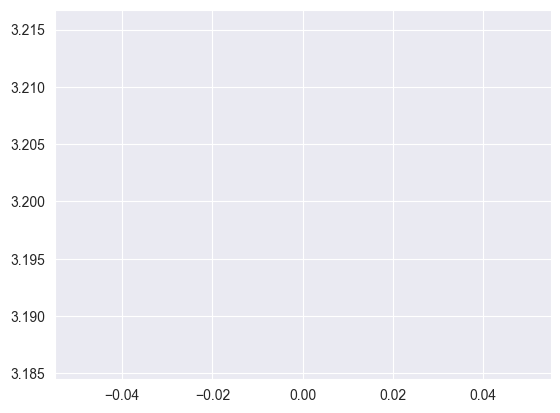

Batch 12
Training Loss = 3.0474, Training Acc = 0.0700
Validation Loss = 3.0126, Validation Acc = 0.0891



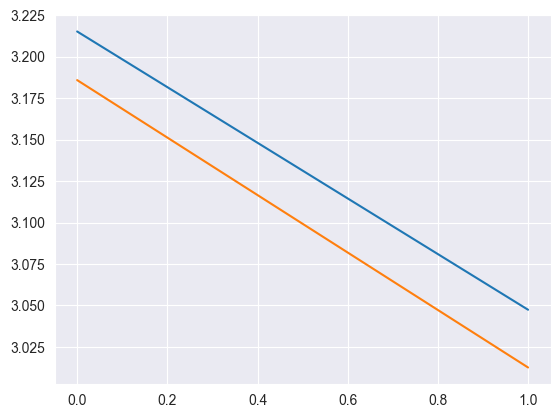

Batch 24
Training Loss = 2.7032, Training Acc = 0.1470
Validation Loss = 2.7402, Validation Acc = 0.1341



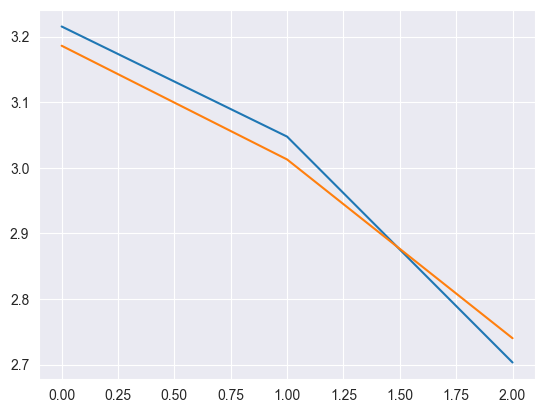

Batch 36
Training Loss = 2.6069, Training Acc = 0.1510
Validation Loss = 2.5827, Validation Acc = 0.1705



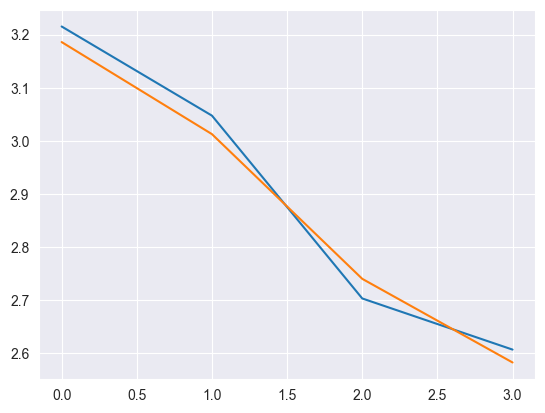

Batch 48
Training Loss = 2.4333, Training Acc = 0.2090
Validation Loss = 2.4962, Validation Acc = 0.1908



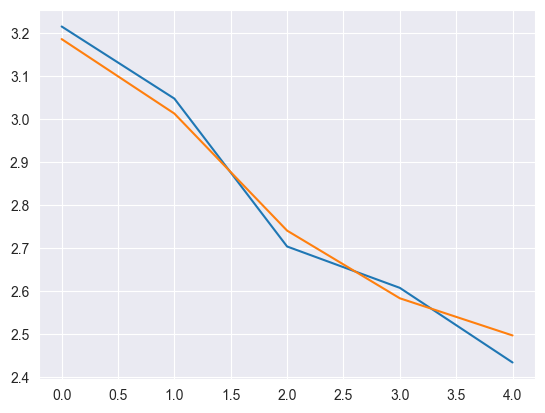

Batch 60
Training Loss = 2.4611, Training Acc = 0.2000
Validation Loss = 2.4364, Validation Acc = 0.2096



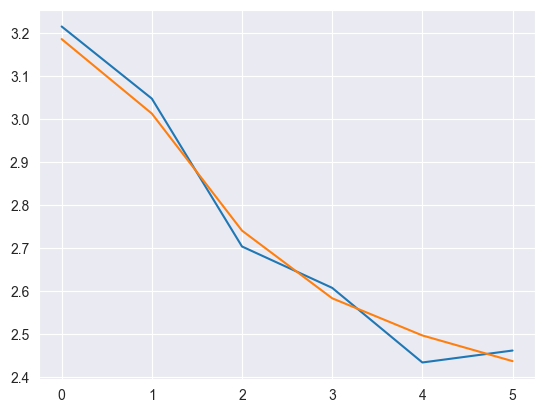

Batch 72
Training Loss = 2.3584, Training Acc = 0.2240
Validation Loss = 2.4019, Validation Acc = 0.2142



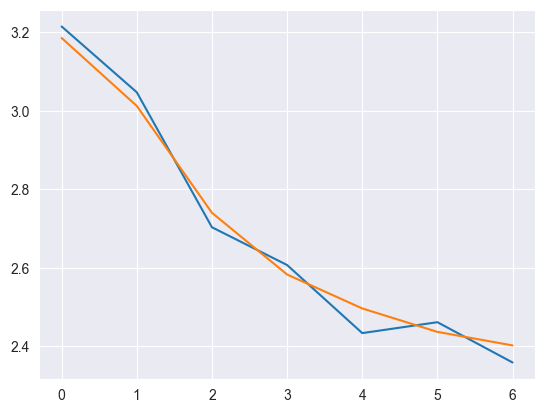

Batch 84
Training Loss = 2.3255, Training Acc = 0.2530
Validation Loss = 2.3221, Validation Acc = 0.2310



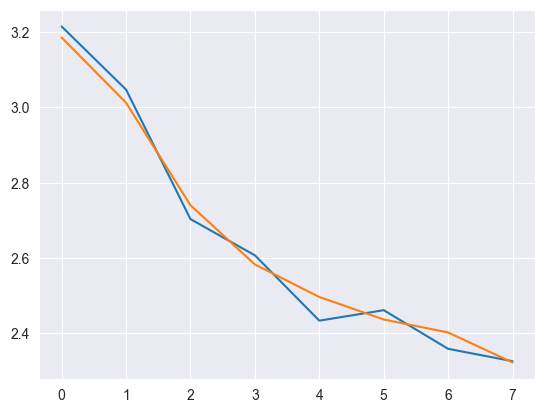

Batch 96
Training Loss = 2.2595, Training Acc = 0.2600
Validation Loss = 2.3071, Validation Acc = 0.2383



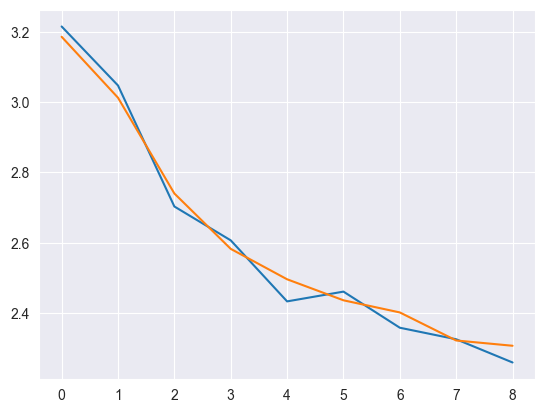

Batch 108
Training Loss = 2.2348, Training Acc = 0.2610
Validation Loss = 2.2616, Validation Acc = 0.2544



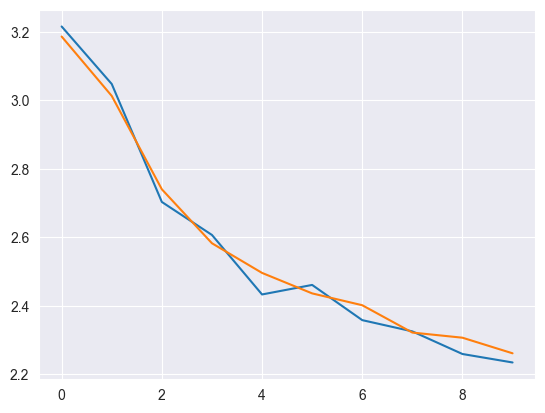

Batch 120
Training Loss = 2.2567, Training Acc = 0.2660
Validation Loss = 2.2449, Validation Acc = 0.2553



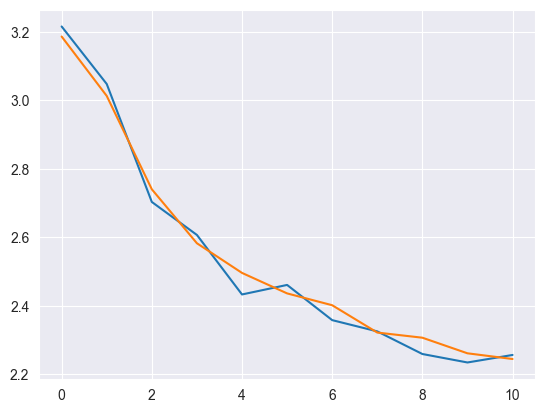

Batch 129
Training Loss = 2.1338, Training Acc = 0.2812
Validation Loss = 2.2222, Validation Acc = 0.2616



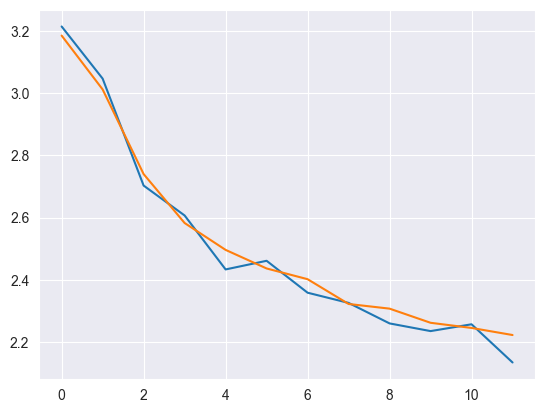

Batch 130
Training Loss = 2.1600, Training Acc = 0.2890
Validation Loss = 2.2263, Validation Acc = 0.2619



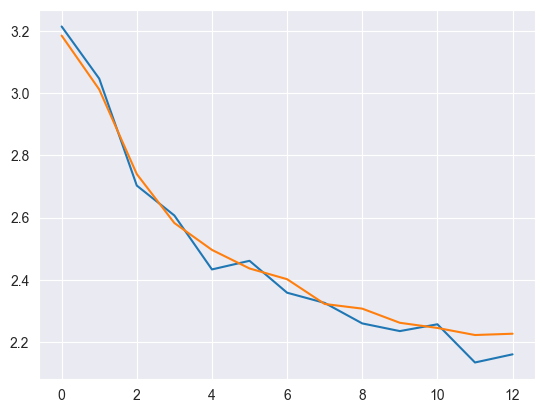

Batch 131
Training Loss = 2.2187, Training Acc = 0.2660
Validation Loss = 2.1845, Validation Acc = 0.2680



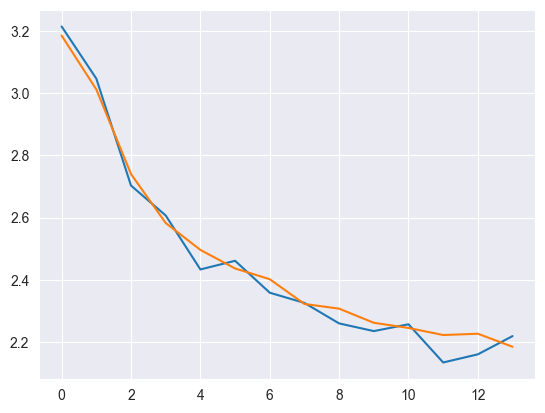

Batch 132
Training Loss = 2.1020, Training Acc = 0.3160
Validation Loss = 2.2154, Validation Acc = 0.2570



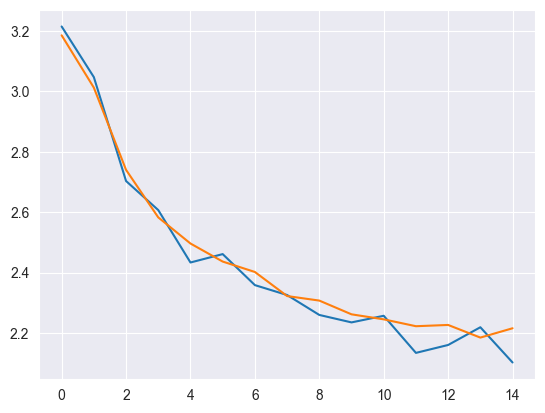

Batch 133
Training Loss = 2.2091, Training Acc = 0.2650
Validation Loss = 2.2472, Validation Acc = 0.2506



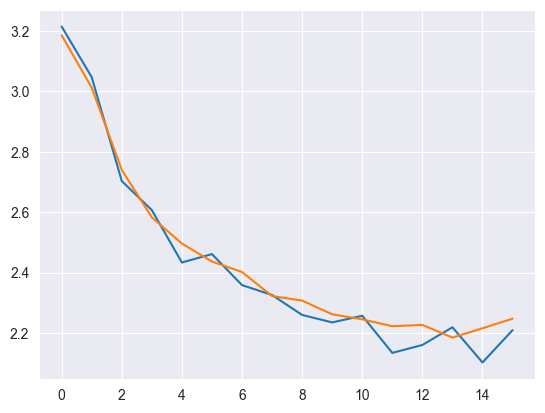

Batch 134
Training Loss = 2.2690, Training Acc = 0.2630
Validation Loss = 2.1943, Validation Acc = 0.2648



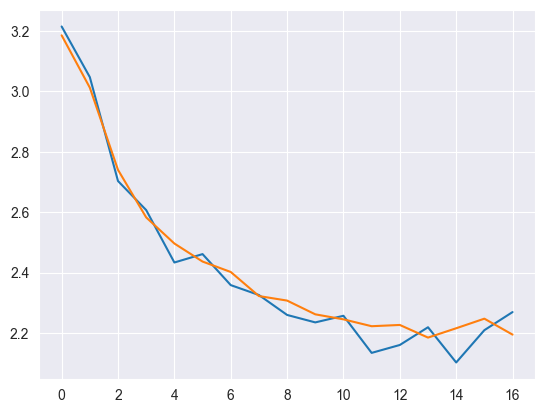

Batch 135
Training Loss = 2.1742, Training Acc = 0.2950
Validation Loss = 2.2121, Validation Acc = 0.2611



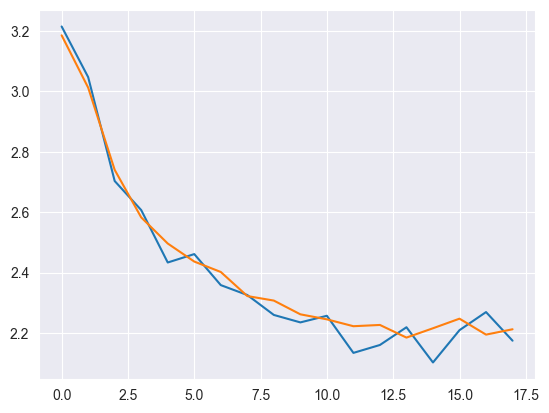

Batch 136
Training Loss = 2.2306, Training Acc = 0.2540
Validation Loss = 2.2024, Validation Acc = 0.2701



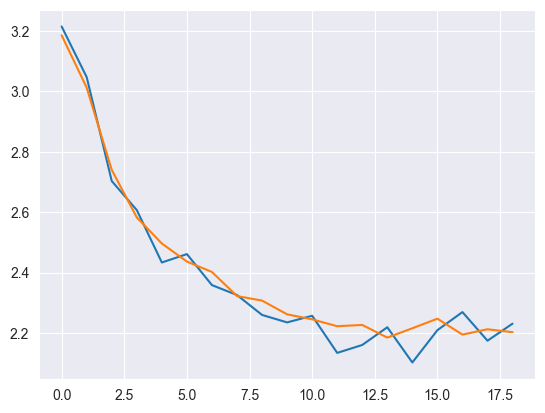

Batch 137
Training Loss = 2.2590, Training Acc = 0.2790
Validation Loss = 2.1823, Validation Acc = 0.2739



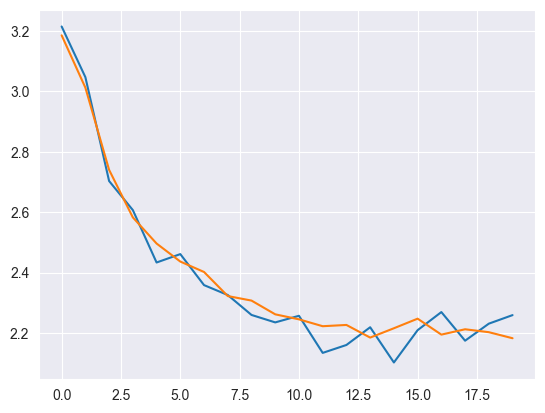

Batch 138
Training Loss = 2.1562, Training Acc = 0.2650
Validation Loss = 2.1928, Validation Acc = 0.2701



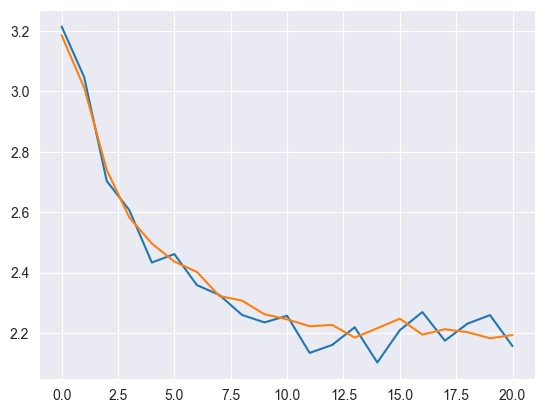

Batch 139
Training Loss = 2.1331, Training Acc = 0.2710
Validation Loss = 2.2137, Validation Acc = 0.2677



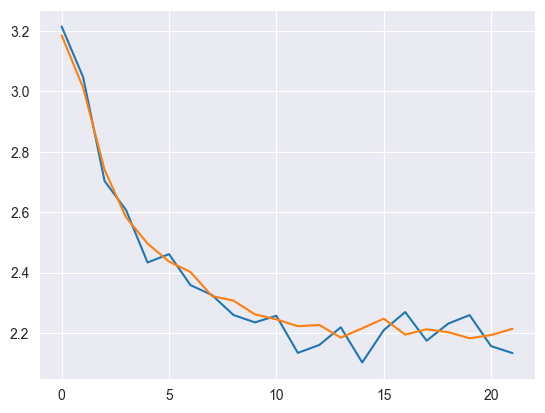

Batch 140
Training Loss = 2.2896, Training Acc = 0.2700
Validation Loss = 2.1815, Validation Acc = 0.2734



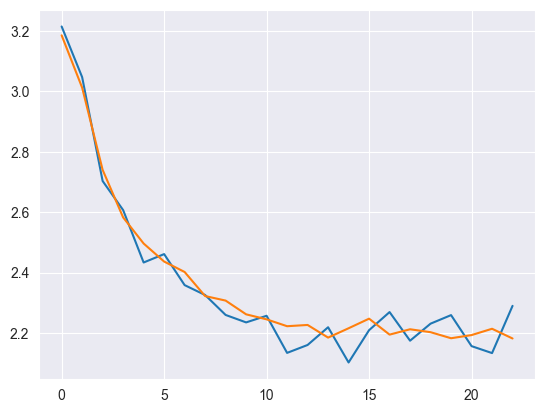

Batch 141
Training Loss = 2.1663, Training Acc = 0.2760
Validation Loss = 2.1900, Validation Acc = 0.2734



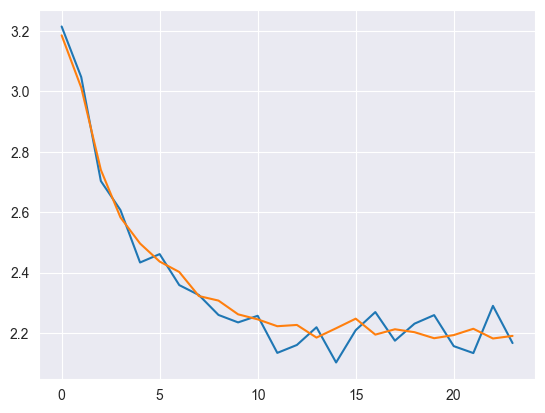

Batch 142
Training Loss = 2.1921, Training Acc = 0.2710
Validation Loss = 2.2270, Validation Acc = 0.2668



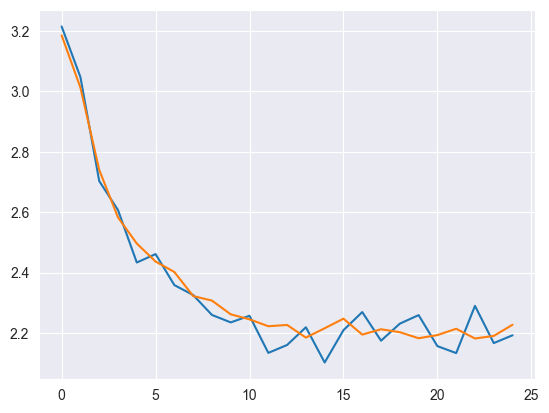

Batch 143
Training Loss = 2.1899, Training Acc = 0.2790
Validation Loss = 2.1673, Validation Acc = 0.2752



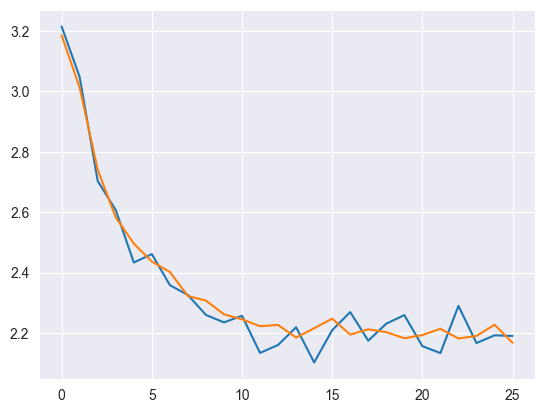

Batch 144
Training Loss = 2.1825, Training Acc = 0.2780
Validation Loss = 2.1703, Validation Acc = 0.2733



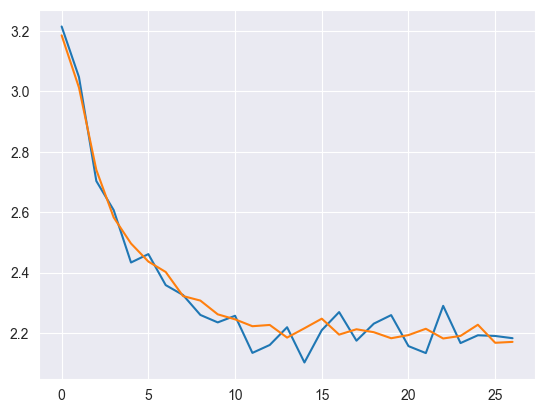

Batch 145
Training Loss = 2.1253, Training Acc = 0.2990
Validation Loss = 2.1704, Validation Acc = 0.2787



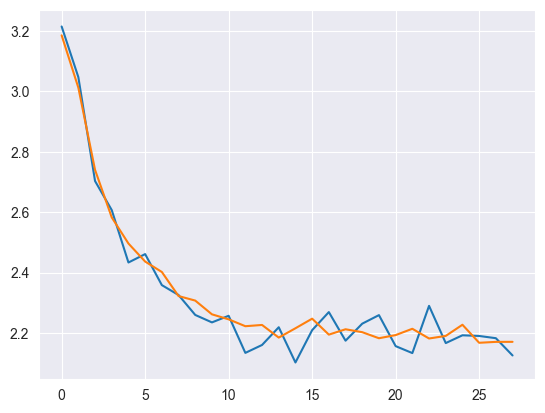

Batch 146
Training Loss = 2.1279, Training Acc = 0.2790
Validation Loss = 2.1608, Validation Acc = 0.2791



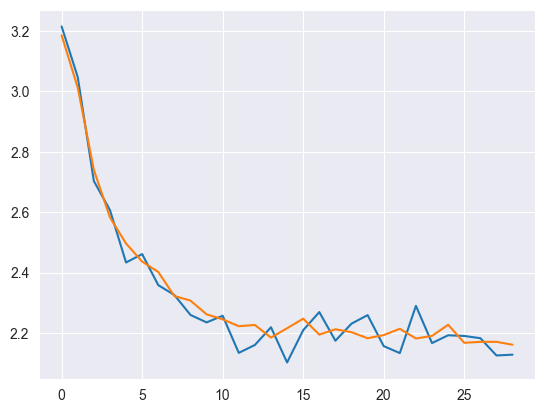

Batch 147
Training Loss = 2.1558, Training Acc = 0.2610
Validation Loss = 2.1616, Validation Acc = 0.2794



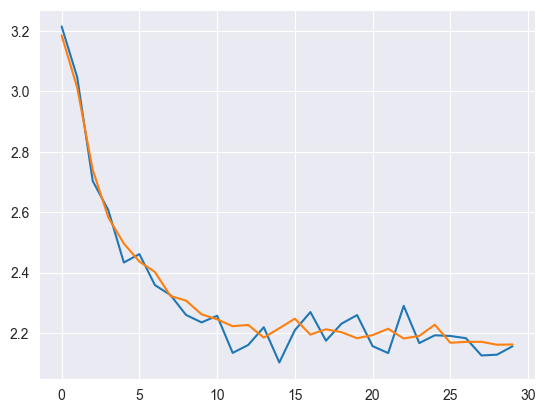

Batch 148
Training Loss = 2.1192, Training Acc = 0.2980
Validation Loss = 2.1768, Validation Acc = 0.2795



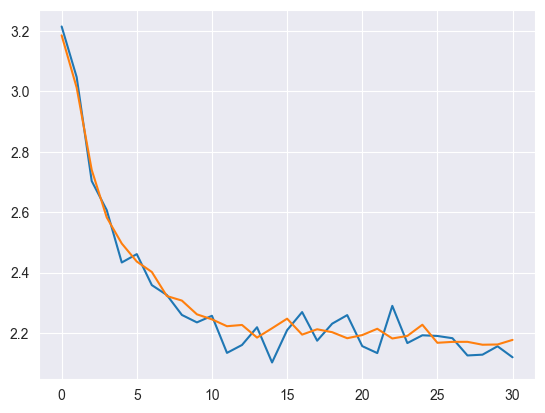

Batch 149
Training Loss = 2.1564, Training Acc = 0.2910
Validation Loss = 2.1567, Validation Acc = 0.2805



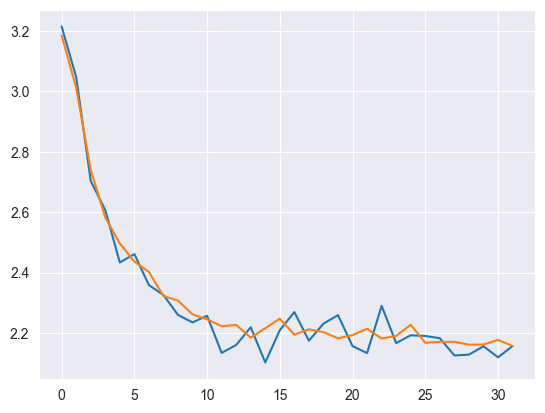

Batch 150
Training Loss = 2.1482, Training Acc = 0.3060
Validation Loss = 2.1466, Validation Acc = 0.2825



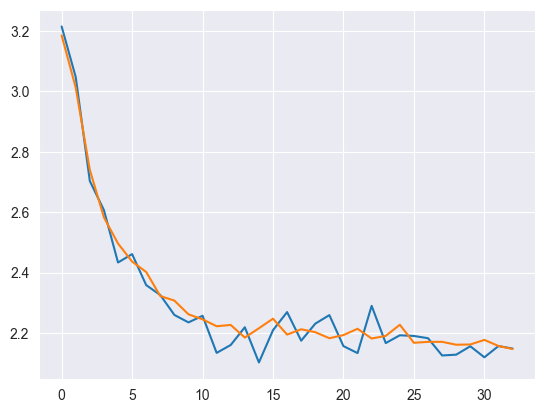

Batch 151
Training Loss = 2.1405, Training Acc = 0.2960
Validation Loss = 2.1534, Validation Acc = 0.2837



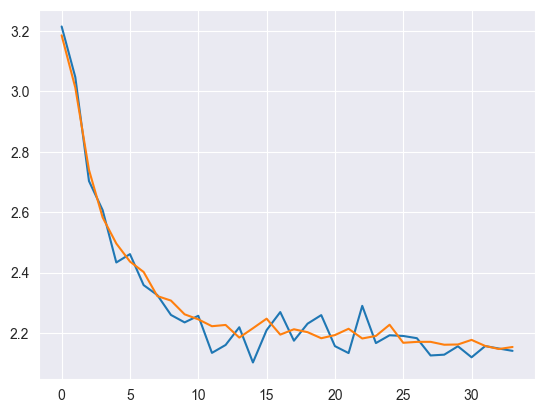

Batch 152
Training Loss = 2.1076, Training Acc = 0.3200
Validation Loss = 2.1483, Validation Acc = 0.2787



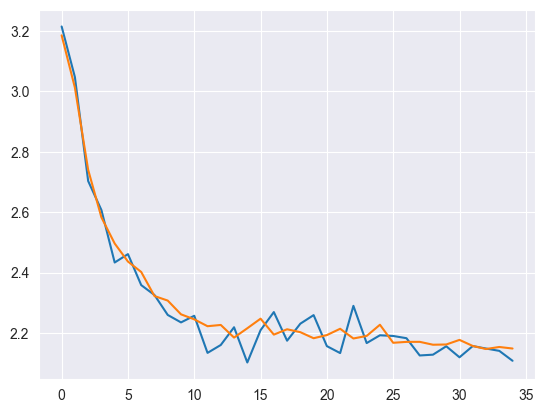

Batch 153
Training Loss = 2.1083, Training Acc = 0.2960
Validation Loss = 2.1443, Validation Acc = 0.2776



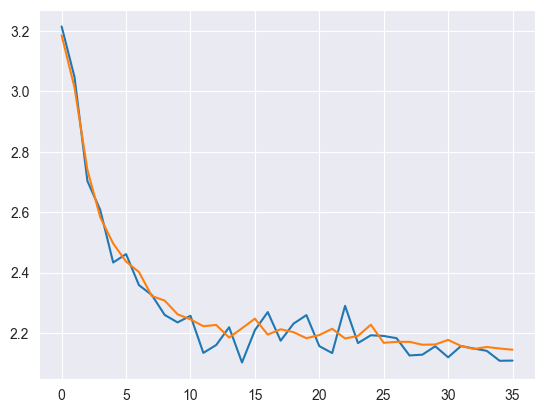

Batch 154
Training Loss = 2.0821, Training Acc = 0.2900
Validation Loss = 2.1468, Validation Acc = 0.2789



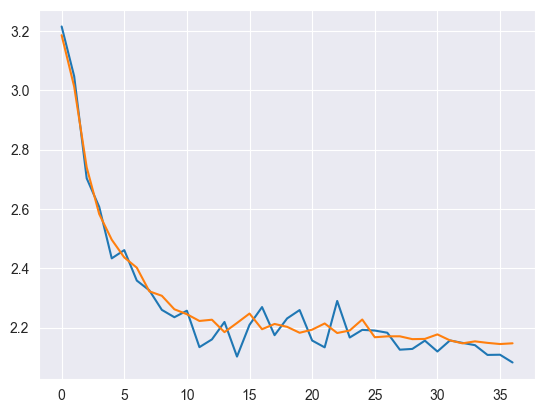

Batch 155
Training Loss = 2.1523, Training Acc = 0.3000
Validation Loss = 2.1386, Validation Acc = 0.2806



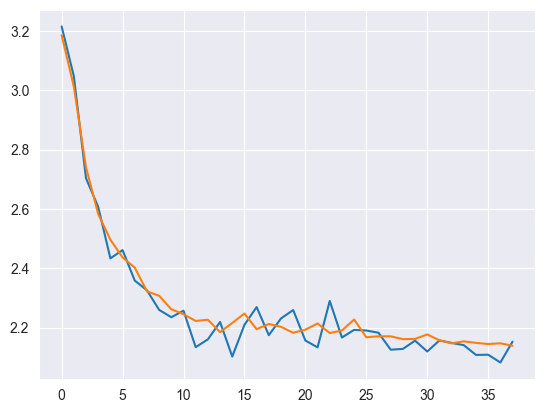

Batch 156
Training Loss = 2.1355, Training Acc = 0.2950
Validation Loss = 2.1261, Validation Acc = 0.2868



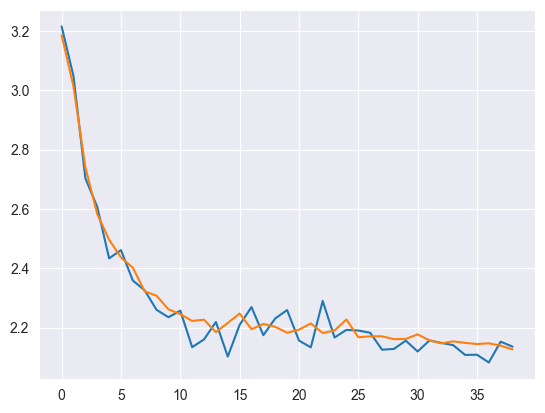

Batch 157
Training Loss = 2.1467, Training Acc = 0.2710
Validation Loss = 2.1717, Validation Acc = 0.2774



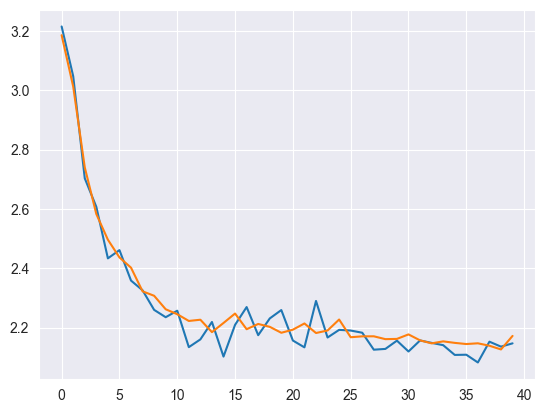

Batch 158
Training Loss = 2.1716, Training Acc = 0.2830
Validation Loss = 2.2234, Validation Acc = 0.2659



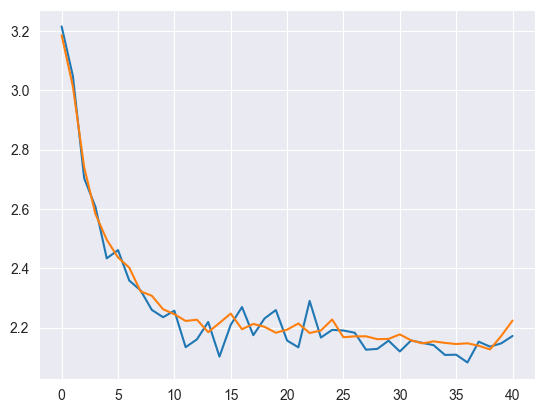

Batch 159
Training Loss = 2.2150, Training Acc = 0.2790
Validation Loss = 2.1741, Validation Acc = 0.2763



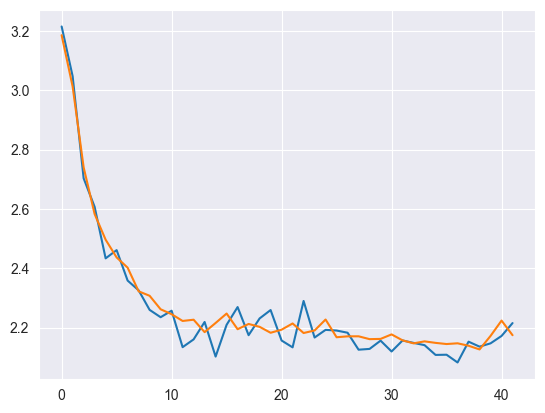

Batch 160
Training Loss = 2.1495, Training Acc = 0.2730
Validation Loss = 2.1493, Validation Acc = 0.2843



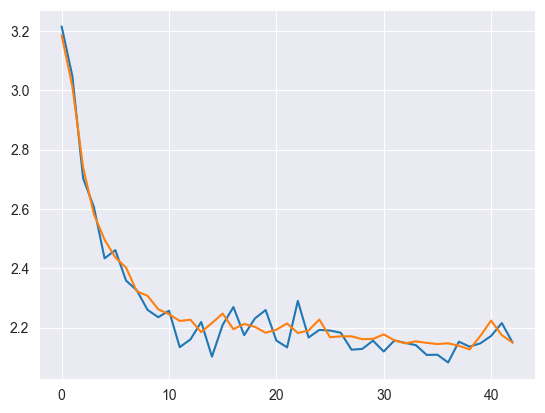

Batch 161
Training Loss = 2.1056, Training Acc = 0.3200
Validation Loss = 2.2124, Validation Acc = 0.2673



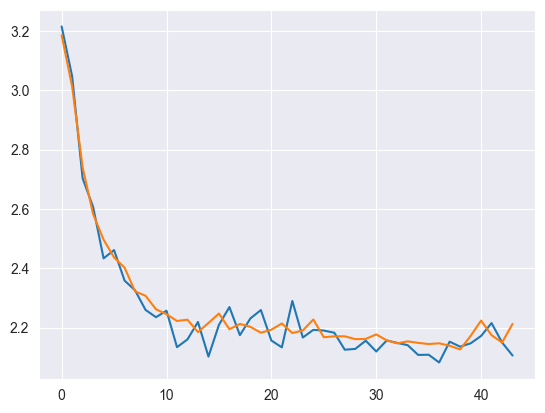

Batch 162
Training Loss = 2.2204, Training Acc = 0.2620
Validation Loss = 2.1285, Validation Acc = 0.2876



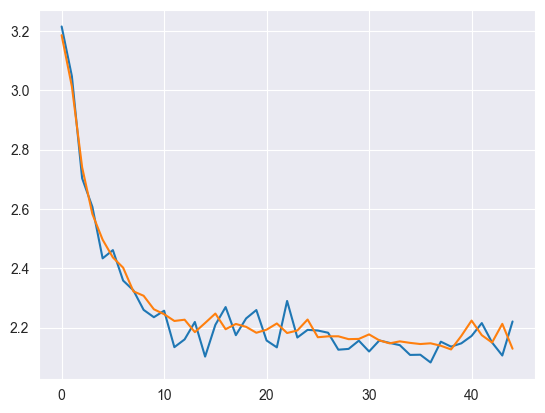

Batch 163
Training Loss = 2.1296, Training Acc = 0.3070
Validation Loss = 2.1893, Validation Acc = 0.2756



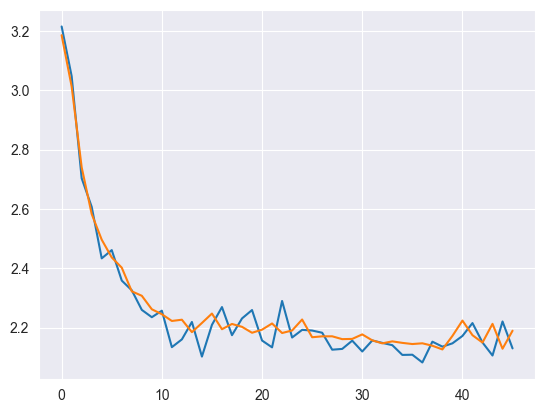

Batch 164
Training Loss = 2.1685, Training Acc = 0.2620
Validation Loss = 2.1365, Validation Acc = 0.2844



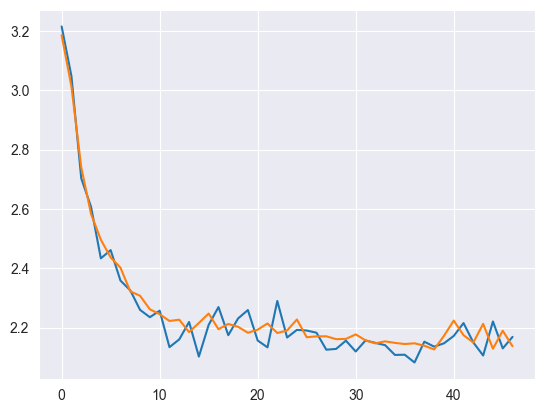

Batch 165
Training Loss = 2.1322, Training Acc = 0.3170
Validation Loss = 2.1595, Validation Acc = 0.2805



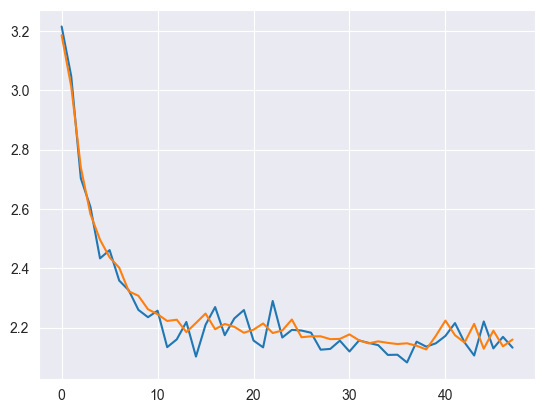

Batch 166
Training Loss = 2.1147, Training Acc = 0.3140
Validation Loss = 2.1247, Validation Acc = 0.2903



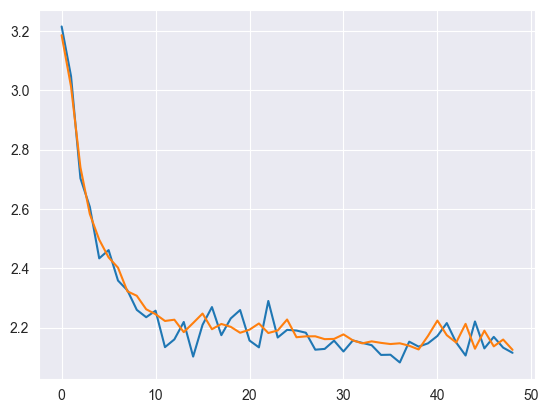

Batch 167
Training Loss = 2.1366, Training Acc = 0.2910
Validation Loss = 2.1382, Validation Acc = 0.2840



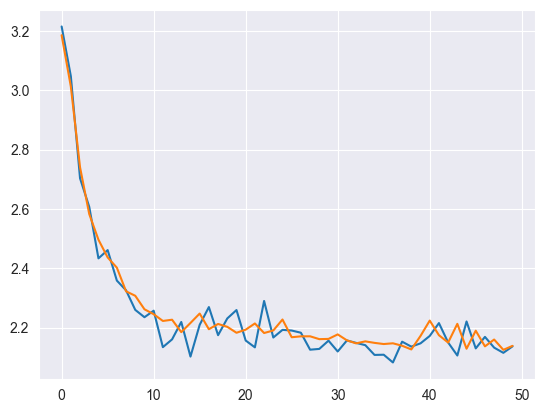

Batch 168
Training Loss = 2.1543, Training Acc = 0.2710
Validation Loss = 2.1367, Validation Acc = 0.2807



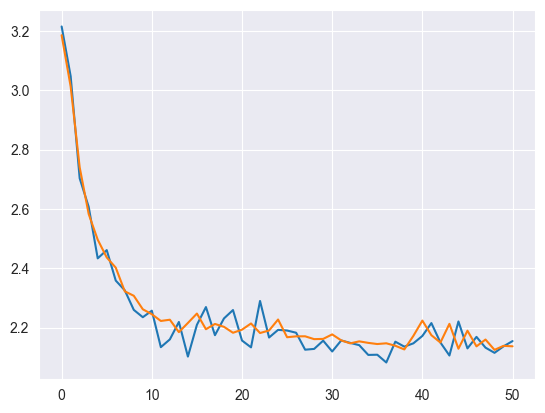

Batch 169
Training Loss = 2.1024, Training Acc = 0.2870
Validation Loss = 2.1201, Validation Acc = 0.2855



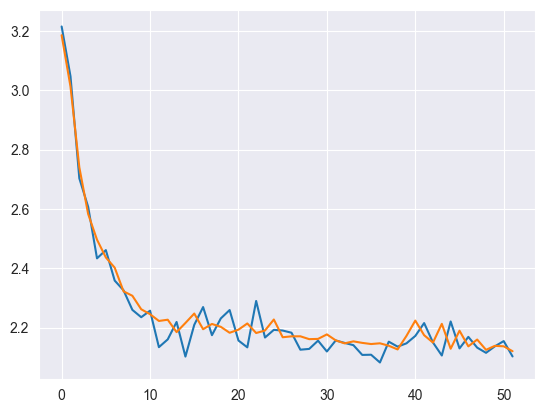

Batch 170
Training Loss = 2.0922, Training Acc = 0.2930
Validation Loss = 2.1277, Validation Acc = 0.2877



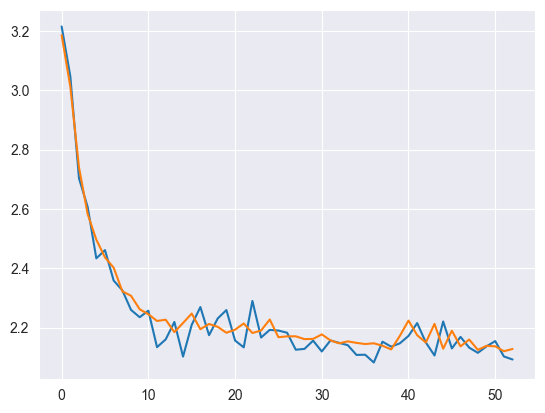

Batch 171
Training Loss = 2.0955, Training Acc = 0.3230
Validation Loss = 2.1030, Validation Acc = 0.2907



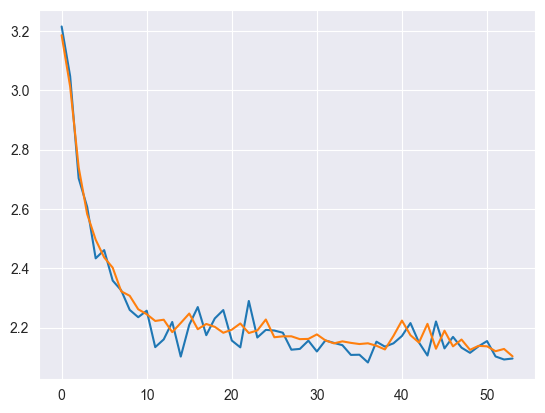

Batch 172
Training Loss = 2.1114, Training Acc = 0.2880
Validation Loss = 2.1167, Validation Acc = 0.2843



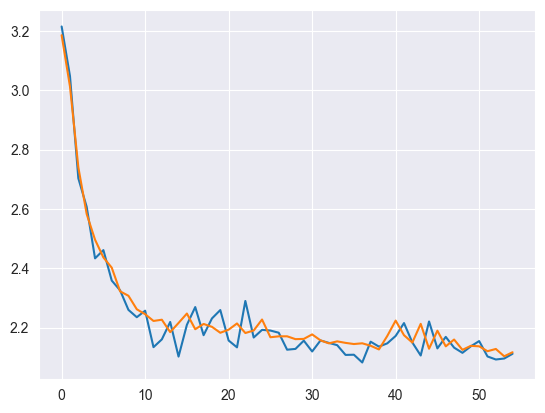

Batch 173
Training Loss = 2.1096, Training Acc = 0.2980
Validation Loss = 2.1002, Validation Acc = 0.2930



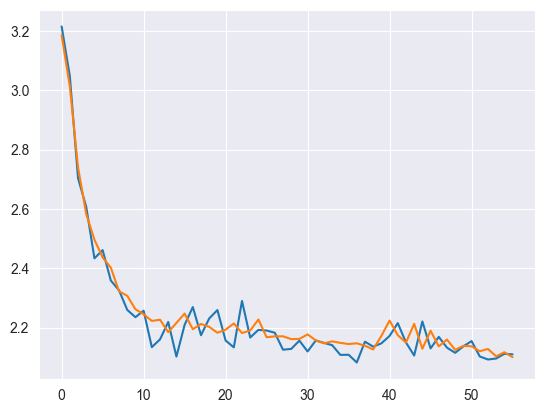

Batch 174
Training Loss = 2.0984, Training Acc = 0.2920
Validation Loss = 2.1003, Validation Acc = 0.2924



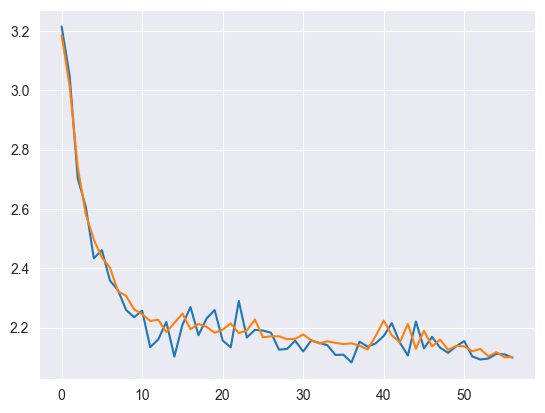

Batch 175
Training Loss = 2.1113, Training Acc = 0.2730
Validation Loss = 2.0984, Validation Acc = 0.2937



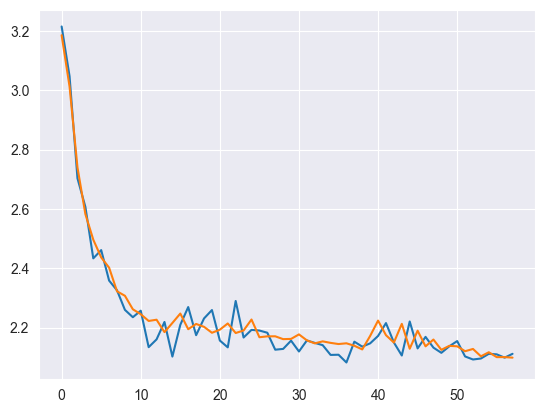

Batch 176
Training Loss = 2.0557, Training Acc = 0.2930
Validation Loss = 2.0919, Validation Acc = 0.2965



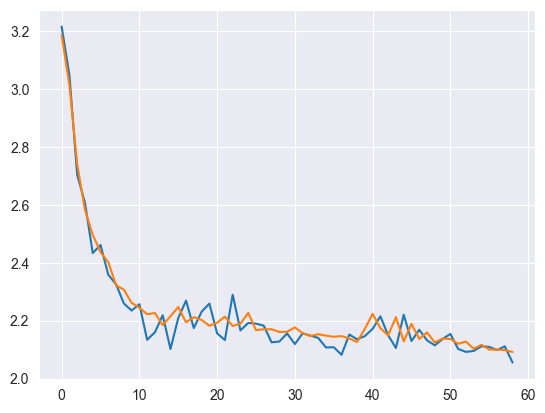

Batch 177
Training Loss = 2.0647, Training Acc = 0.3160
Validation Loss = 2.0920, Validation Acc = 0.2960



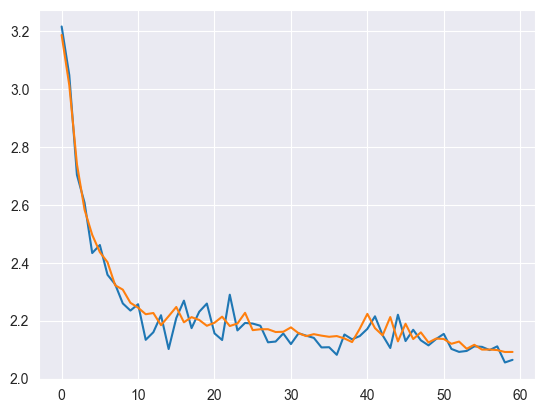

Batch 178
Training Loss = 2.0409, Training Acc = 0.2970
Validation Loss = 2.0905, Validation Acc = 0.2968



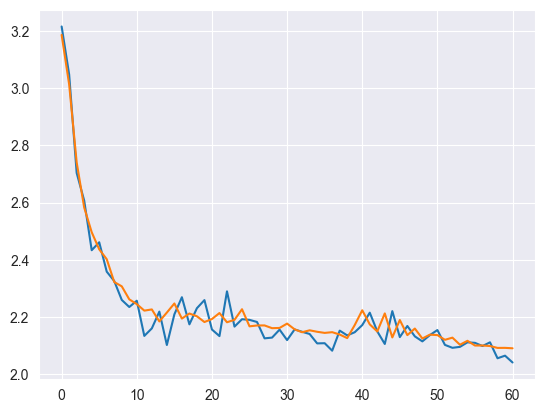

Batch 179
Training Loss = 2.0894, Training Acc = 0.3100
Validation Loss = 2.0951, Validation Acc = 0.2964



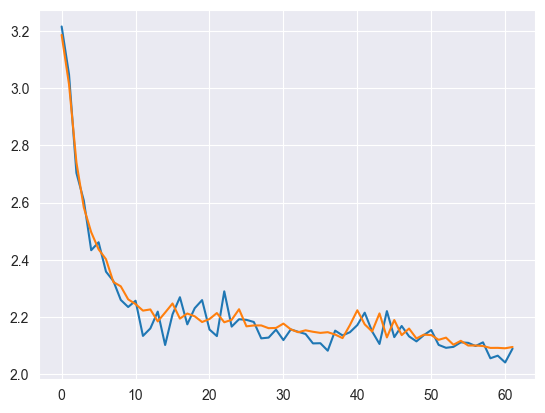

Batch 180
Training Loss = 2.0356, Training Acc = 0.3270
Validation Loss = 2.0923, Validation Acc = 0.2965



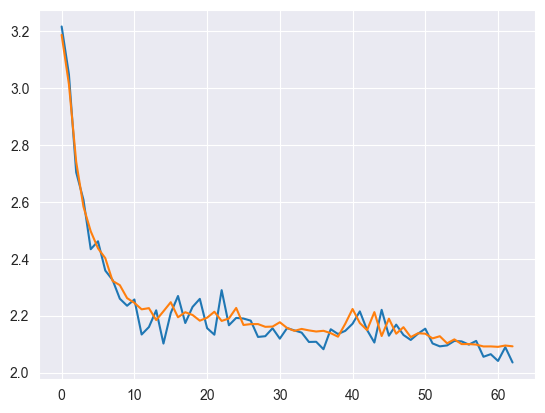

Batch 181
Training Loss = 2.0368, Training Acc = 0.2970
Validation Loss = 2.0913, Validation Acc = 0.2940



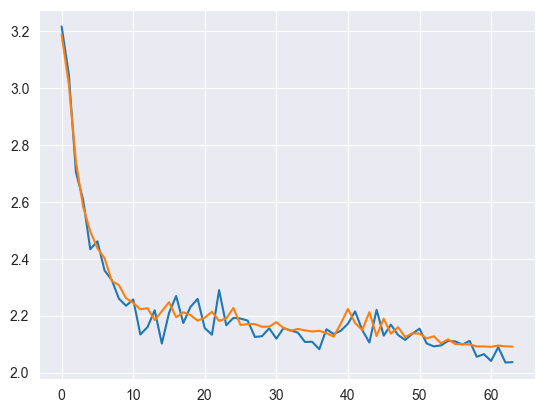

Batch 182
Training Loss = 2.0322, Training Acc = 0.3270
Validation Loss = 2.1343, Validation Acc = 0.2879



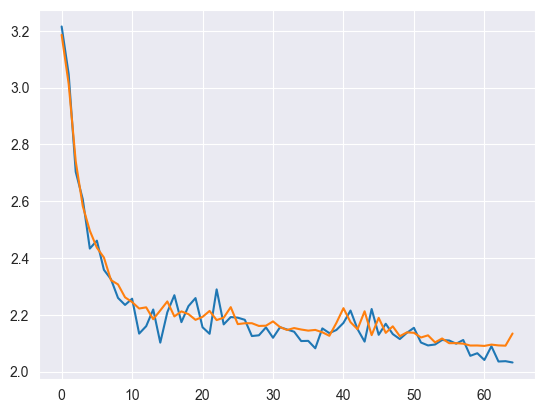

Batch 183
Training Loss = 2.0859, Training Acc = 0.2870
Validation Loss = 2.1086, Validation Acc = 0.2908



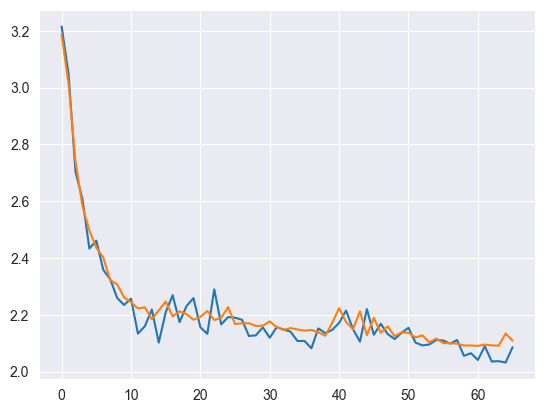

Batch 184
Training Loss = 2.0561, Training Acc = 0.2950
Validation Loss = 2.0923, Validation Acc = 0.2964



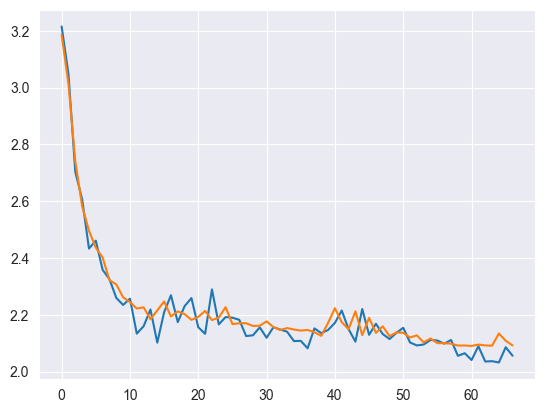

Batch 185
Training Loss = 2.0441, Training Acc = 0.3070
Validation Loss = 2.0797, Validation Acc = 0.2996



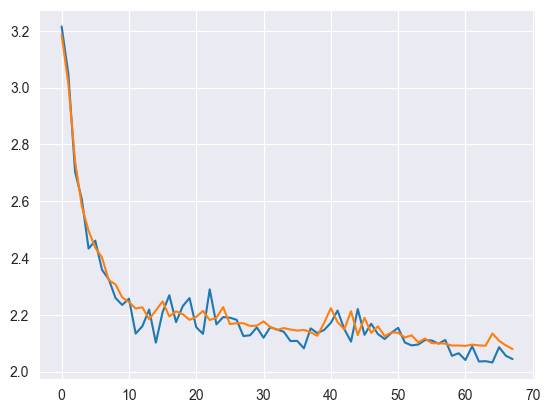

Batch 186
Training Loss = 2.1088, Training Acc = 0.2830
Validation Loss = 2.0868, Validation Acc = 0.2959



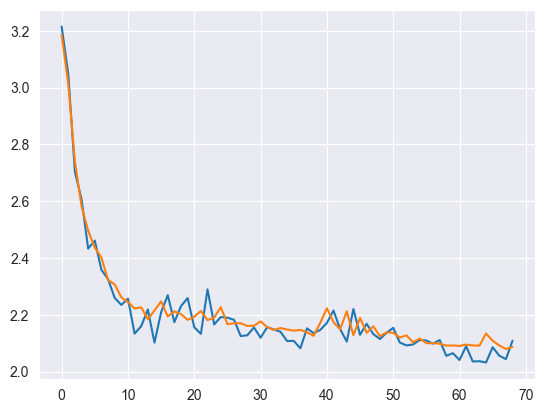

Batch 187
Training Loss = 1.9950, Training Acc = 0.3280
Validation Loss = 2.0978, Validation Acc = 0.3007



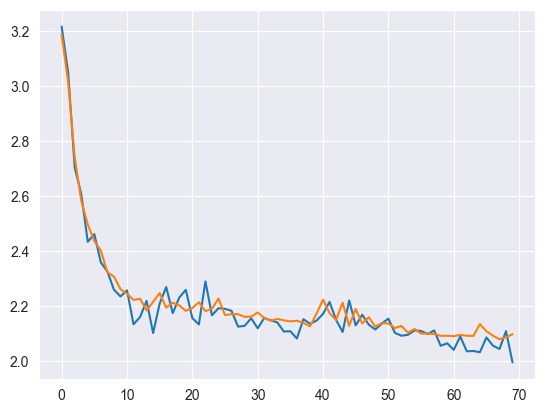

Batch 188
Training Loss = 2.1556, Training Acc = 0.2830
Validation Loss = 2.1124, Validation Acc = 0.2943



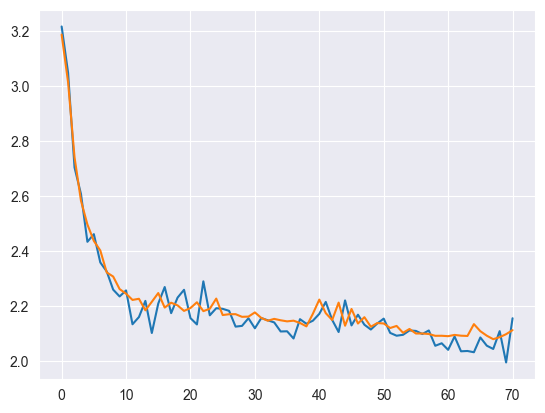

Batch 189
Training Loss = 2.1436, Training Acc = 0.2910
Validation Loss = 2.1387, Validation Acc = 0.2840



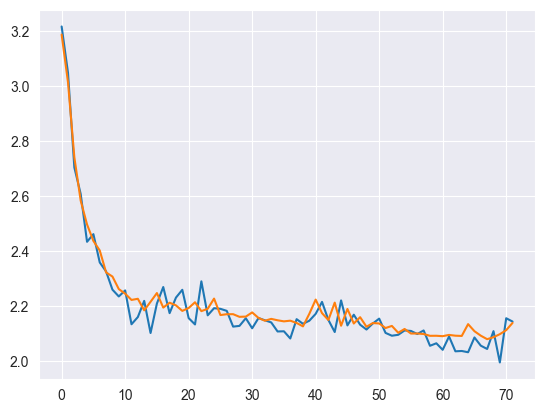

Batch 190
Training Loss = 2.0844, Training Acc = 0.2910
Validation Loss = 2.0888, Validation Acc = 0.2956



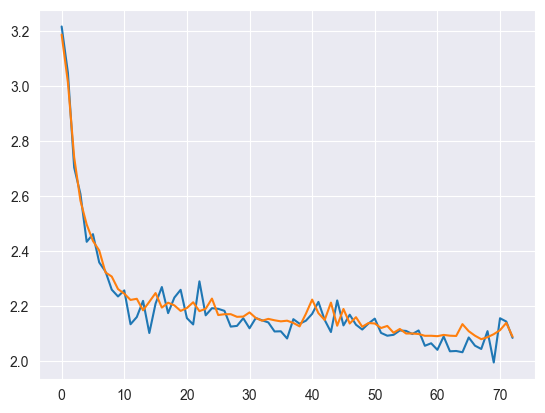

Batch 191
Training Loss = 2.1034, Training Acc = 0.3010
Validation Loss = 2.0747, Validation Acc = 0.3011



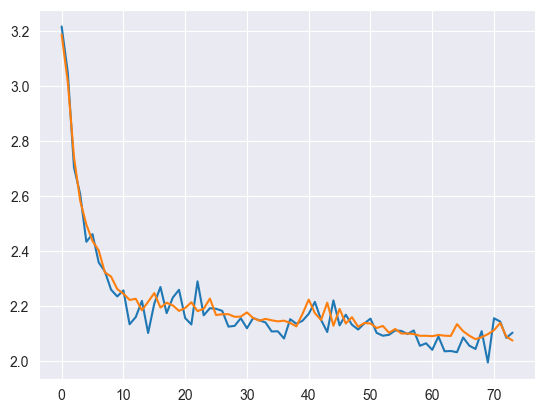

Batch 192
Training Loss = 2.0807, Training Acc = 0.2950
Validation Loss = 2.2480, Validation Acc = 0.2620



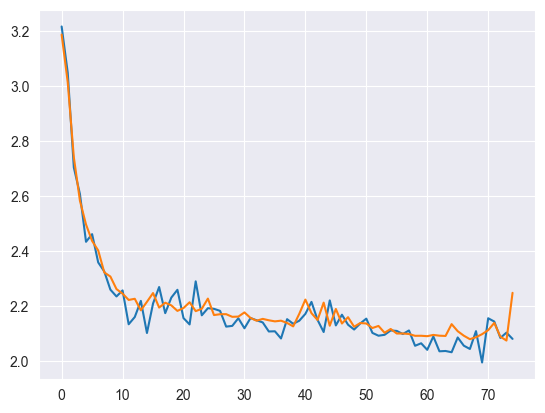

Batch 193
Training Loss = 2.2273, Training Acc = 0.2640
Validation Loss = 2.2517, Validation Acc = 0.2684



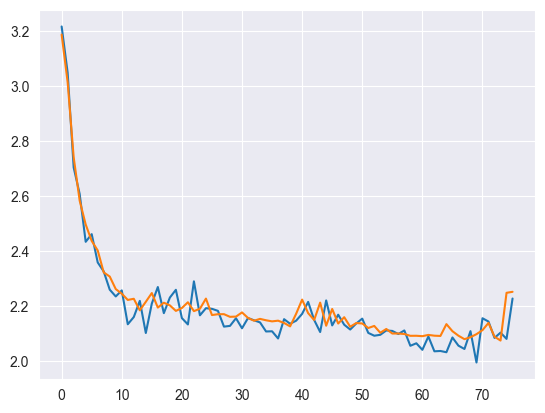

Batch 194
Training Loss = 2.2222, Training Acc = 0.2770
Validation Loss = 2.0849, Validation Acc = 0.2982



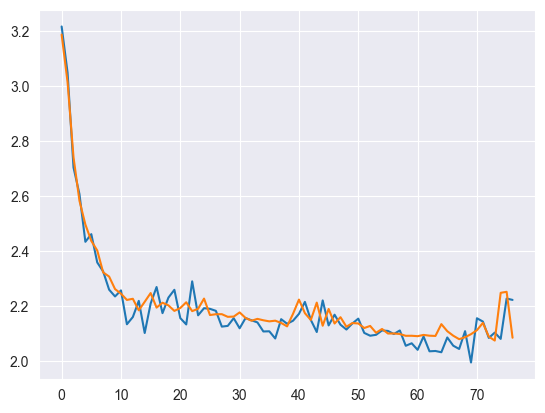

Batch 195
Training Loss = 2.0752, Training Acc = 0.2960
Validation Loss = 2.3476, Validation Acc = 0.2386



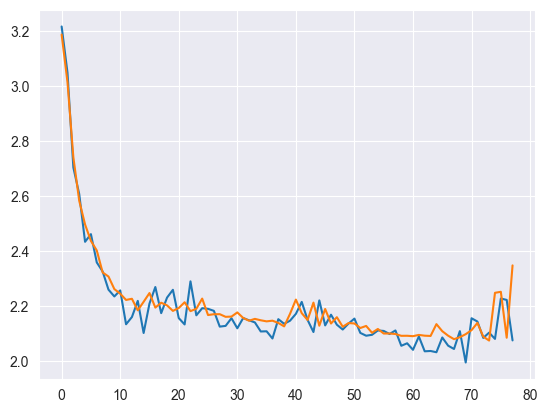

Batch 196
Training Loss = 2.3973, Training Acc = 0.2270
Validation Loss = 2.0820, Validation Acc = 0.3000



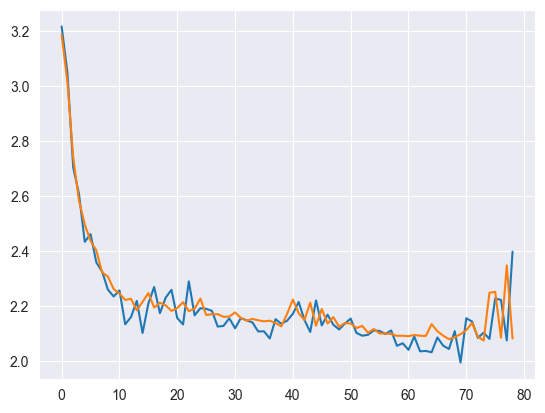

Batch 197
Training Loss = 2.0881, Training Acc = 0.2920
Validation Loss = 2.2182, Validation Acc = 0.2710



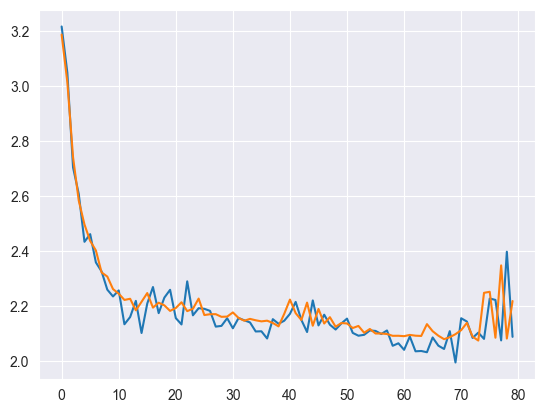

Batch 198
Training Loss = 2.1311, Training Acc = 0.2990
Validation Loss = 2.1111, Validation Acc = 0.2879



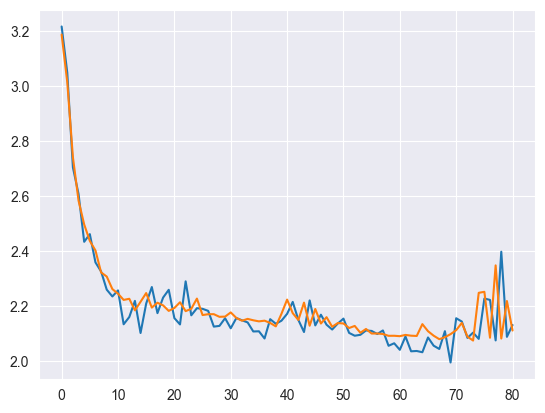

Batch 199
Training Loss = 2.0416, Training Acc = 0.2740
Validation Loss = 2.1702, Validation Acc = 0.2750



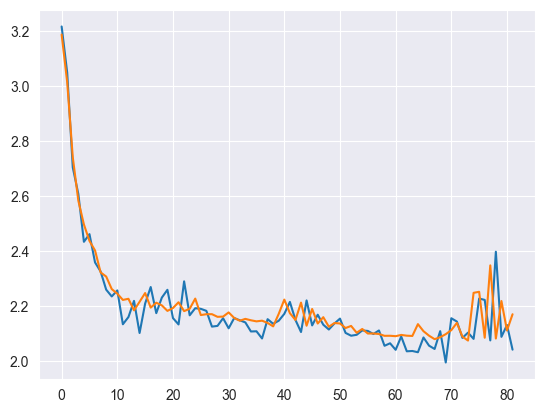

Batch 200
Training Loss = 2.1944, Training Acc = 0.2800
Validation Loss = 2.1069, Validation Acc = 0.2953



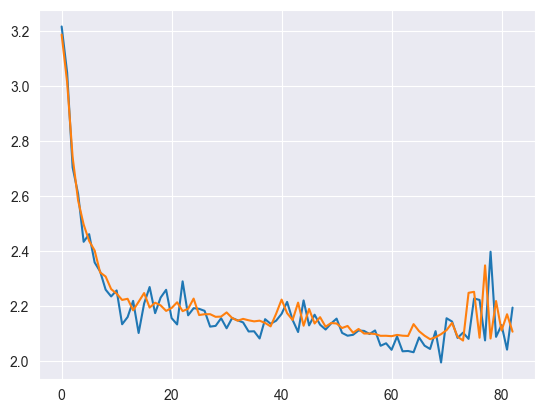

Batch 201
Training Loss = 2.0359, Training Acc = 0.3330
Validation Loss = 2.1141, Validation Acc = 0.2888



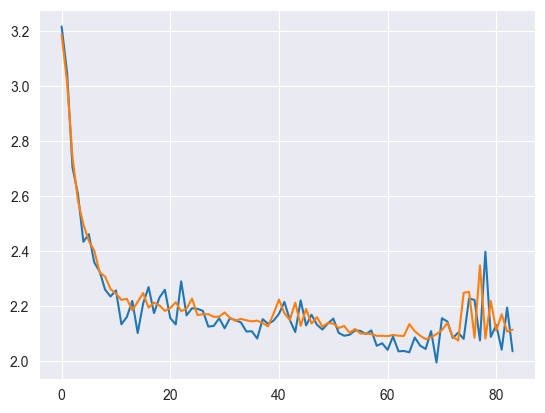

Batch 202
Training Loss = 2.1153, Training Acc = 0.2880
Validation Loss = 2.1301, Validation Acc = 0.2827



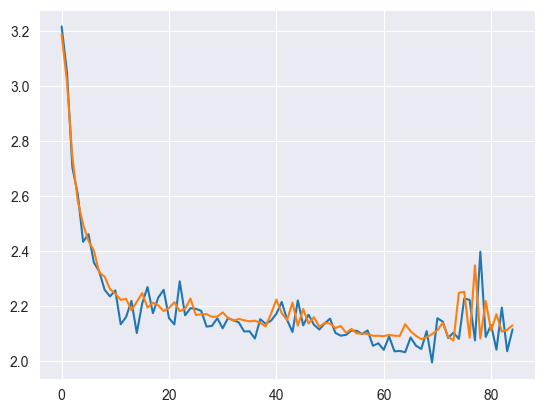

Batch 203
Training Loss = 2.0931, Training Acc = 0.2990
Validation Loss = 2.0924, Validation Acc = 0.2987



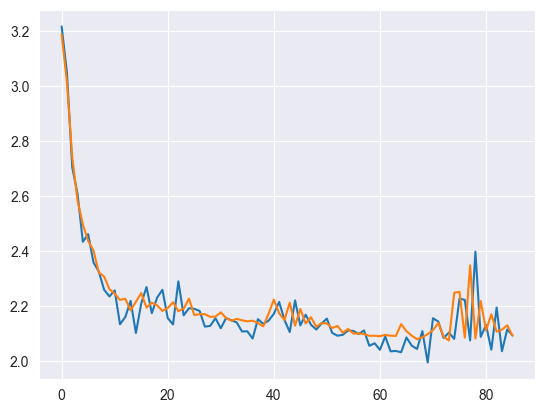

Batch 204
Training Loss = 2.0512, Training Acc = 0.3260
Validation Loss = 2.1244, Validation Acc = 0.2920



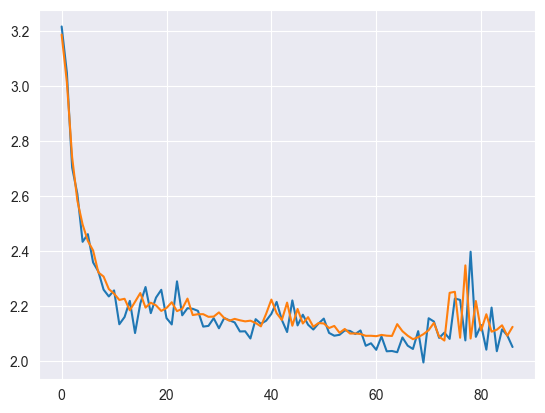

Batch 205
Training Loss = 2.1017, Training Acc = 0.3000
Validation Loss = 2.1040, Validation Acc = 0.2920



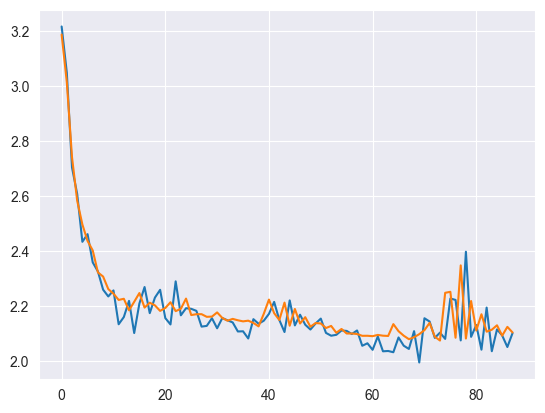

Batch 206
Training Loss = 2.1265, Training Acc = 0.2720
Validation Loss = 2.1101, Validation Acc = 0.2895



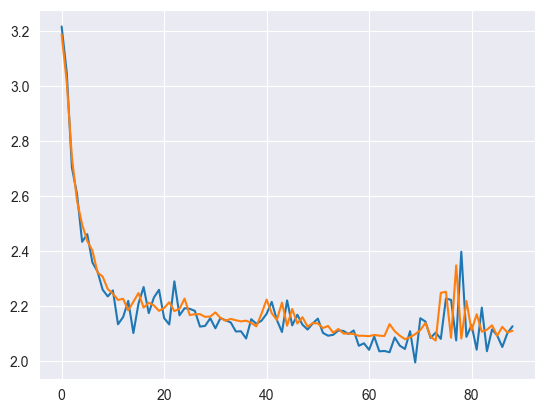

Batch 207
Training Loss = 2.0731, Training Acc = 0.3020
Validation Loss = 2.0791, Validation Acc = 0.3041



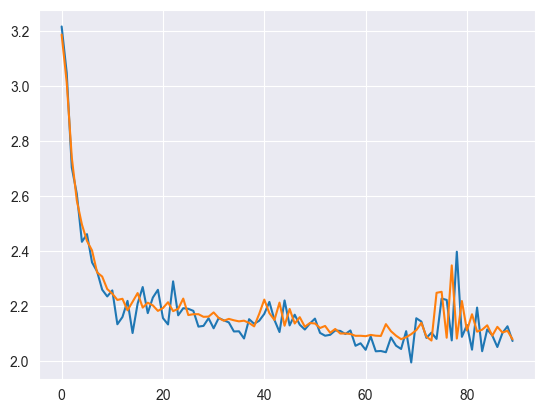

Batch 208
Training Loss = 2.0299, Training Acc = 0.3190
Validation Loss = 2.0901, Validation Acc = 0.3021



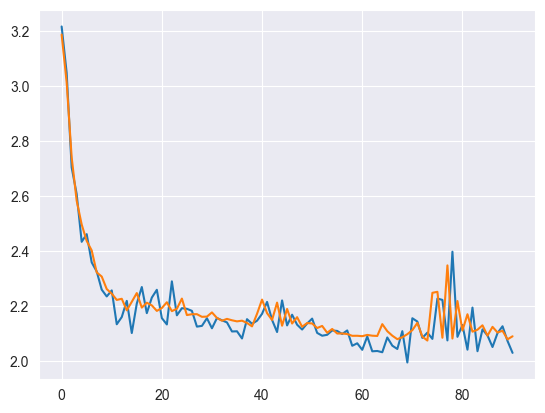

Batch 209
Training Loss = 2.0318, Training Acc = 0.3260
Validation Loss = 2.1071, Validation Acc = 0.2980



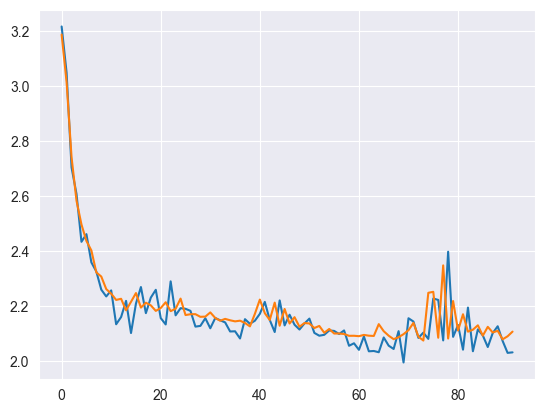

Batch 210
Training Loss = 2.0891, Training Acc = 0.3190
Validation Loss = 2.0839, Validation Acc = 0.3023



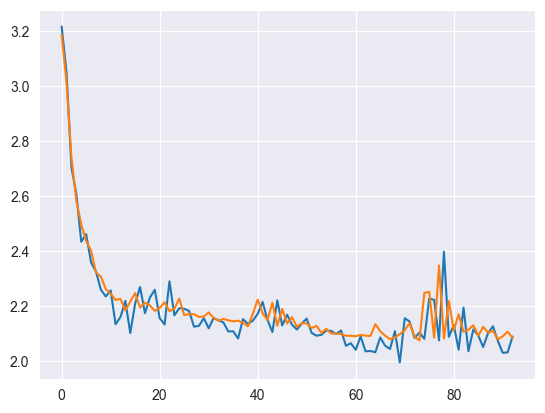

Batch 211
Training Loss = 2.0554, Training Acc = 0.2920
Validation Loss = 2.0778, Validation Acc = 0.3023



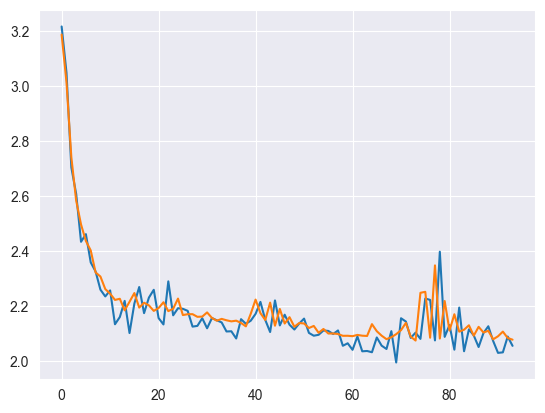

Batch 212
Training Loss = 2.0422, Training Acc = 0.3060
Validation Loss = 2.0686, Validation Acc = 0.3057



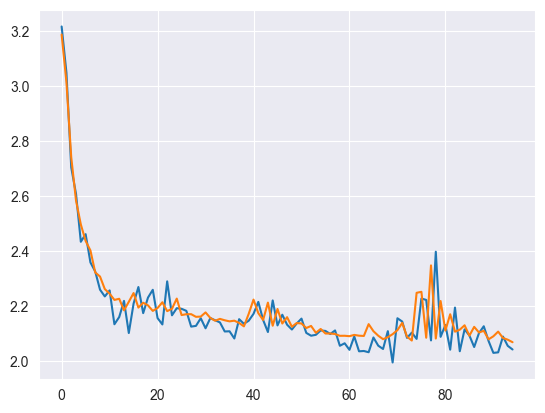

Batch 213
Training Loss = 2.0812, Training Acc = 0.3070
Validation Loss = 2.0699, Validation Acc = 0.3041



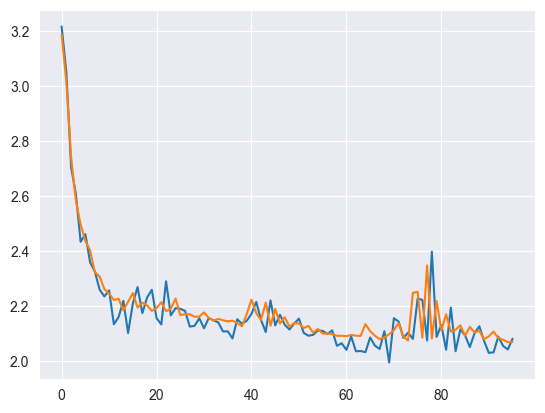

Batch 214
Training Loss = 2.0055, Training Acc = 0.3050
Validation Loss = 2.0594, Validation Acc = 0.3075



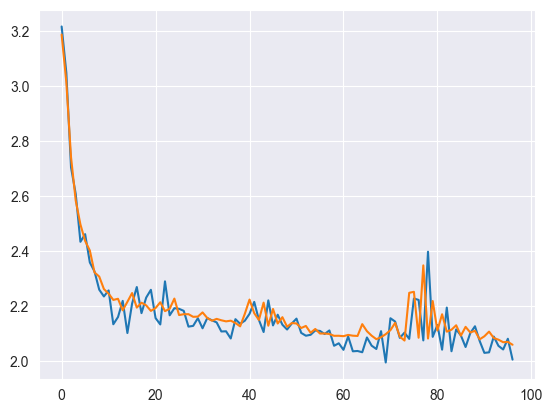

Batch 215
Training Loss = 2.0336, Training Acc = 0.3080
Validation Loss = 2.0590, Validation Acc = 0.3098



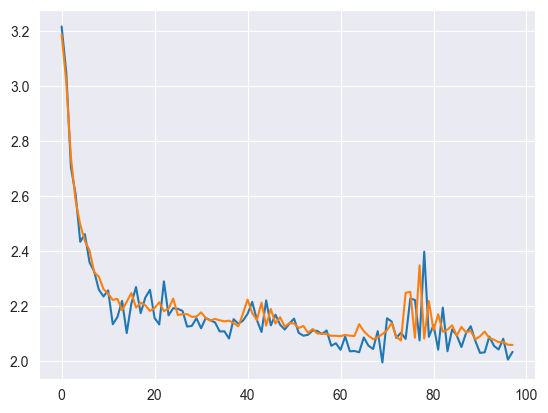

Batch 216
Training Loss = 2.0356, Training Acc = 0.3190
Validation Loss = 2.0614, Validation Acc = 0.3064



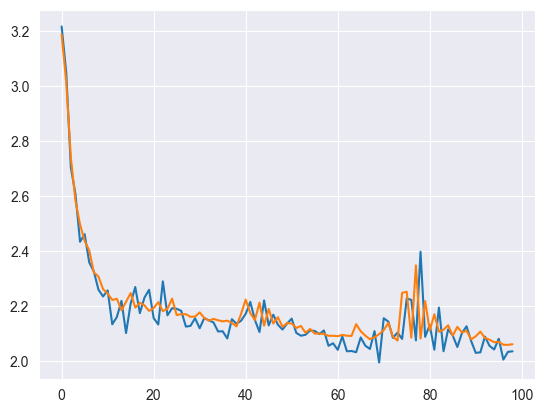

Batch 217
Training Loss = 2.0008, Training Acc = 0.3120
Validation Loss = 2.0571, Validation Acc = 0.3079



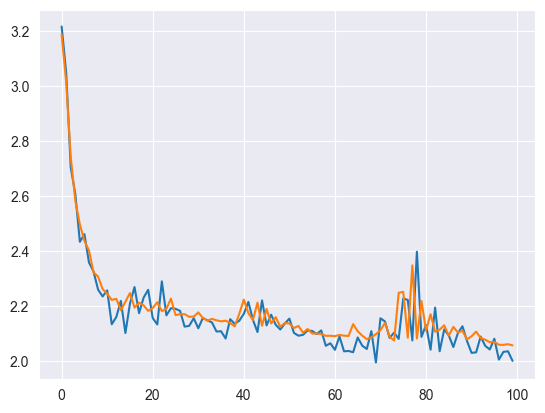

Batch 218
Training Loss = 2.0204, Training Acc = 0.3170
Validation Loss = 2.0517, Validation Acc = 0.3125



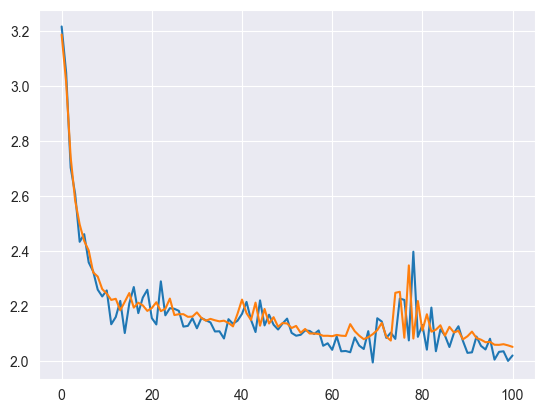

Batch 219
Training Loss = 2.0136, Training Acc = 0.3120
Validation Loss = 2.0495, Validation Acc = 0.3116



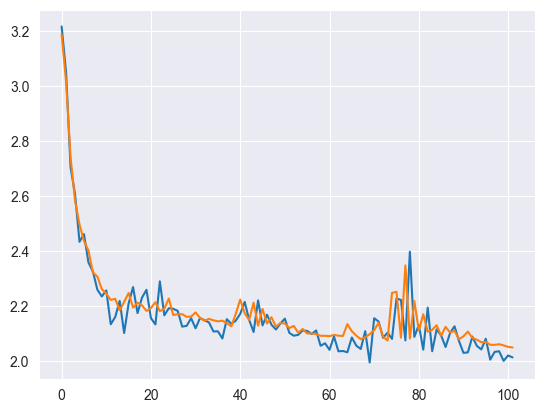

Batch 220
Training Loss = 2.0982, Training Acc = 0.3040
Validation Loss = 2.0596, Validation Acc = 0.3066



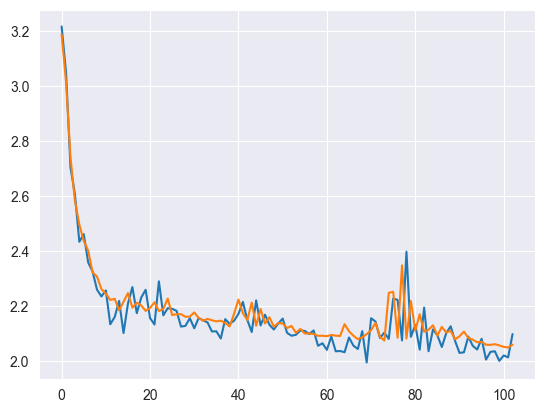

Batch 221
Training Loss = 2.0079, Training Acc = 0.3290
Validation Loss = 2.0481, Validation Acc = 0.3114



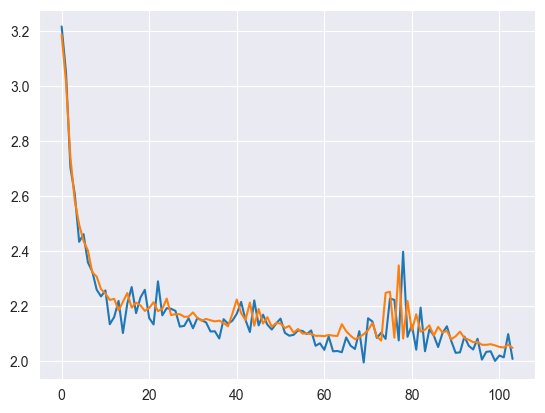

Batch 222
Training Loss = 2.0143, Training Acc = 0.3200
Validation Loss = 2.0553, Validation Acc = 0.3118



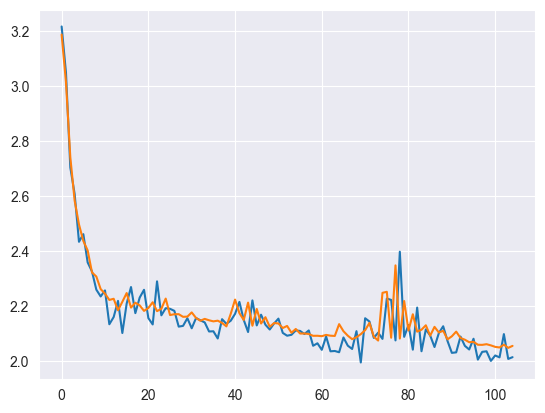

Batch 223
Training Loss = 1.9883, Training Acc = 0.3120
Validation Loss = 2.0347, Validation Acc = 0.3137



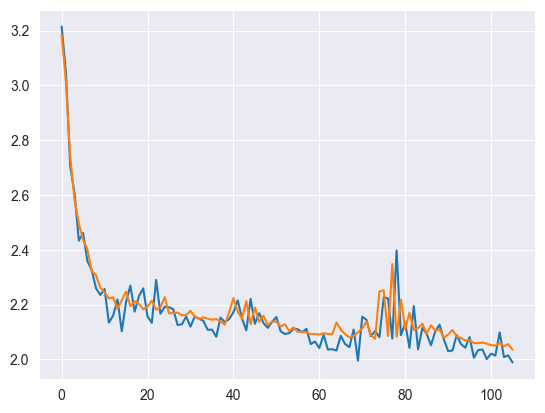

Batch 224
Training Loss = 2.0148, Training Acc = 0.3110
Validation Loss = 2.0456, Validation Acc = 0.3108



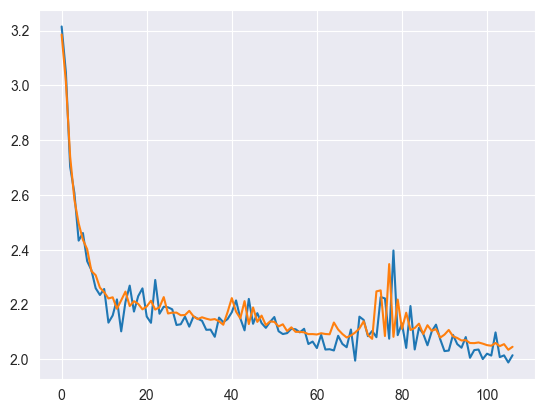

Batch 225
Training Loss = 2.0231, Training Acc = 0.2980
Validation Loss = 2.0504, Validation Acc = 0.3120



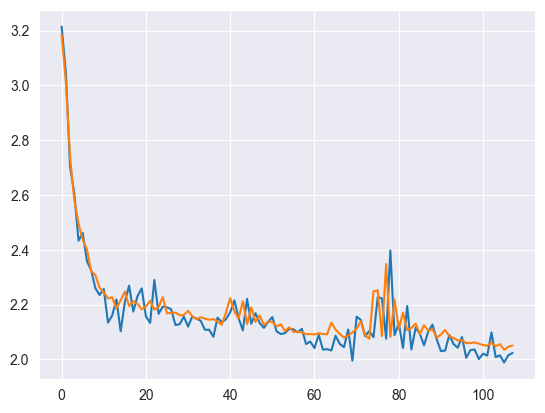

Batch 226
Training Loss = 1.9952, Training Acc = 0.3220
Validation Loss = 2.0341, Validation Acc = 0.3142



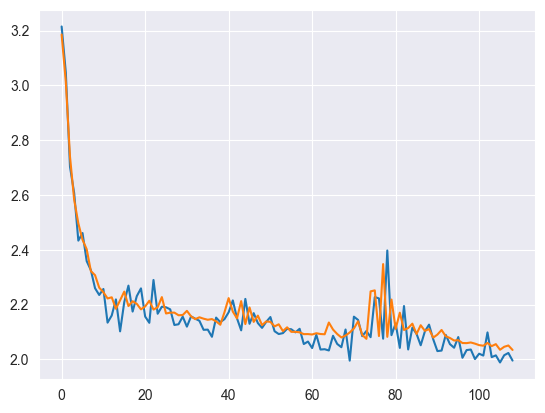

Batch 227
Training Loss = 2.0266, Training Acc = 0.3220
Validation Loss = 2.0426, Validation Acc = 0.3092



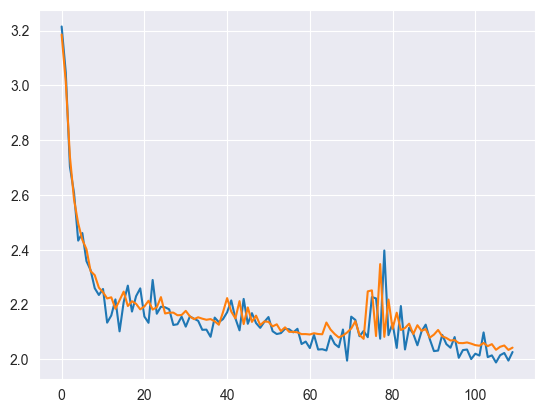

Batch 228
Training Loss = 2.0159, Training Acc = 0.3290
Validation Loss = 2.0703, Validation Acc = 0.3030



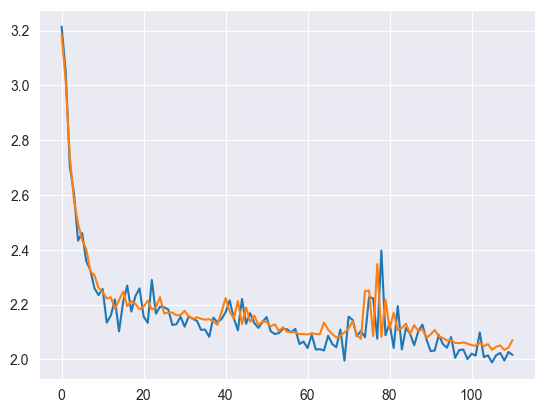

Batch 229
Training Loss = 2.0454, Training Acc = 0.3190
Validation Loss = 2.0363, Validation Acc = 0.3150



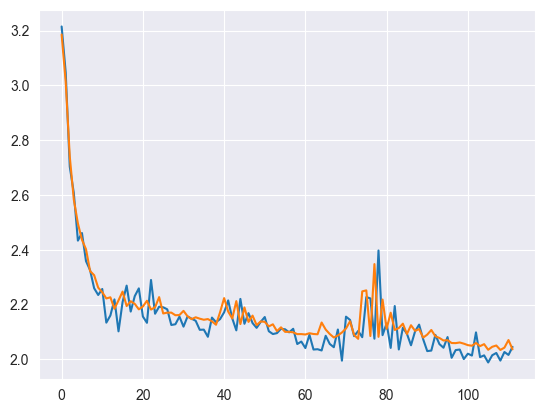

Batch 230
Training Loss = 1.9893, Training Acc = 0.3360
Validation Loss = 2.0904, Validation Acc = 0.2988



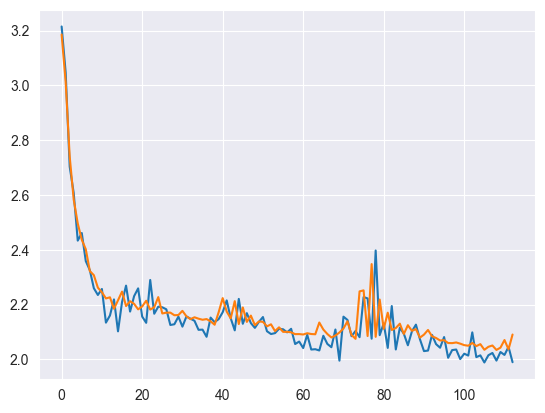

Batch 231
Training Loss = 2.0835, Training Acc = 0.3180
Validation Loss = 2.0435, Validation Acc = 0.3138



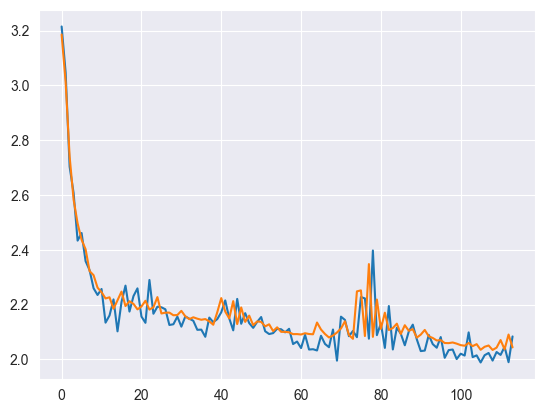

Batch 232
Training Loss = 2.0142, Training Acc = 0.3160
Validation Loss = 2.1005, Validation Acc = 0.3002



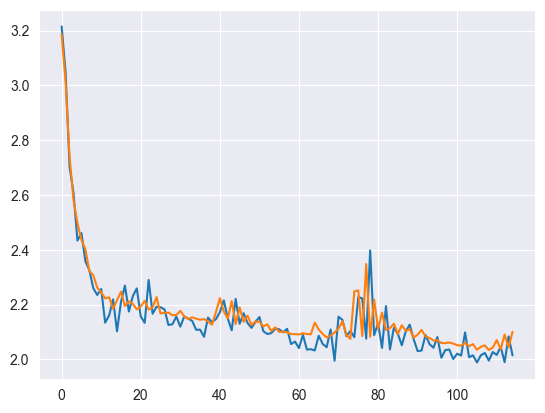

Batch 233
Training Loss = 2.0789, Training Acc = 0.2920
Validation Loss = 2.1119, Validation Acc = 0.2914



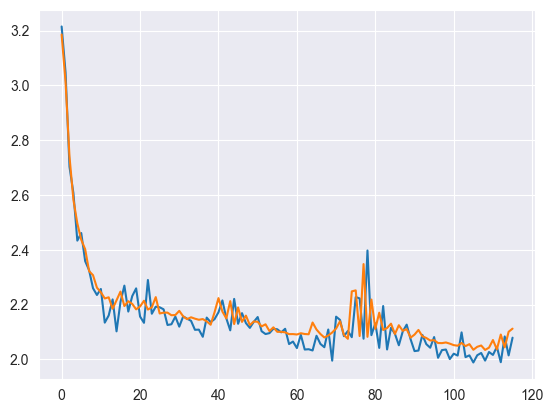

Batch 234
Training Loss = 2.0455, Training Acc = 0.3120
Validation Loss = 2.0585, Validation Acc = 0.3053



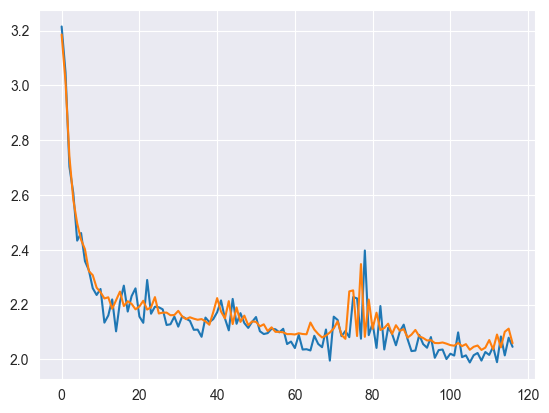

Batch 235
Training Loss = 2.0623, Training Acc = 0.3210
Validation Loss = 2.0938, Validation Acc = 0.3060



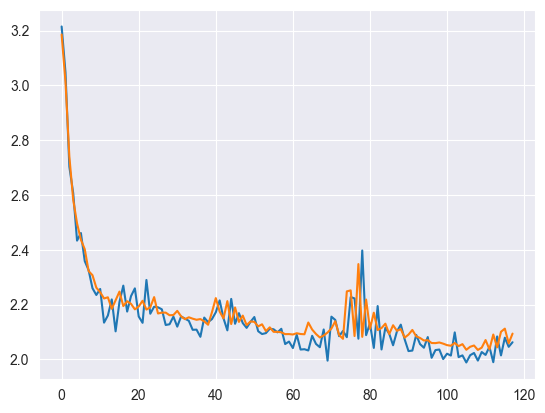

Batch 236
Training Loss = 2.1240, Training Acc = 0.2860
Validation Loss = 2.0453, Validation Acc = 0.3149



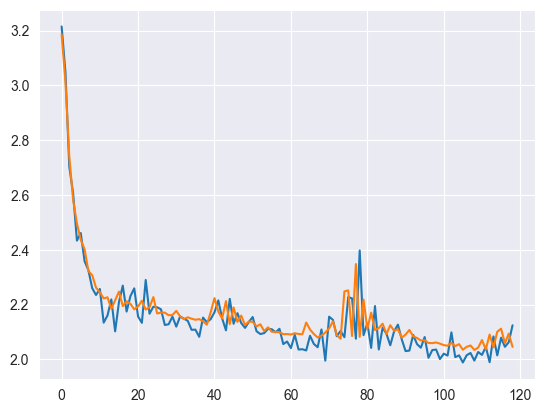

Batch 237
Training Loss = 1.9901, Training Acc = 0.3150
Validation Loss = 2.1455, Validation Acc = 0.2948



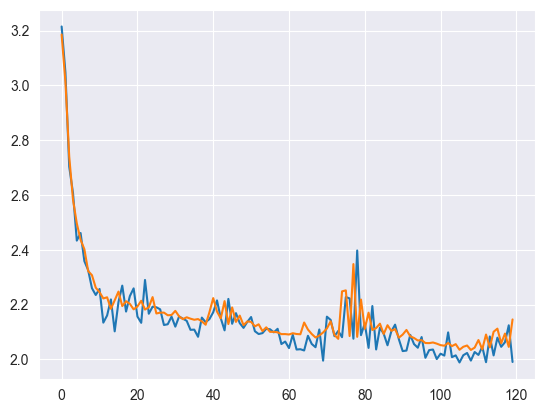

Batch 238
Training Loss = 2.1670, Training Acc = 0.2850
Validation Loss = 2.0299, Validation Acc = 0.3205



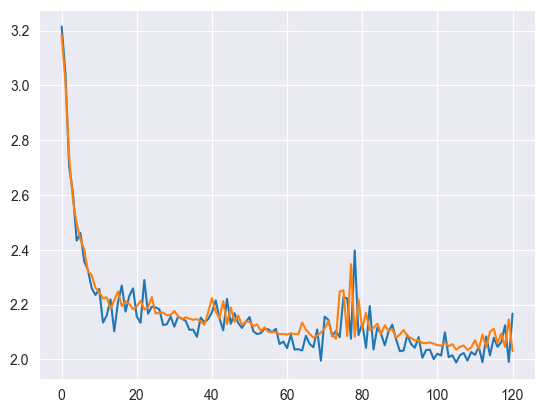

Batch 239
Training Loss = 2.0440, Training Acc = 0.3030
Validation Loss = 2.0946, Validation Acc = 0.3028



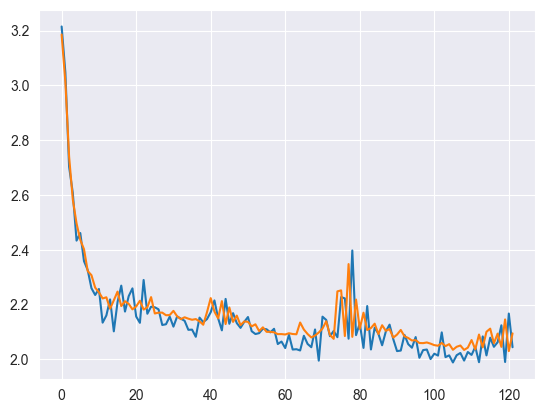

Batch 240
Training Loss = 2.0326, Training Acc = 0.3340
Validation Loss = 2.0543, Validation Acc = 0.3091



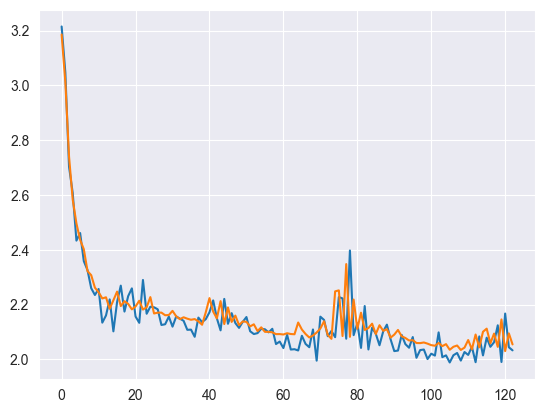

Batch 241
Training Loss = 1.9925, Training Acc = 0.3070
Validation Loss = 2.1044, Validation Acc = 0.2995



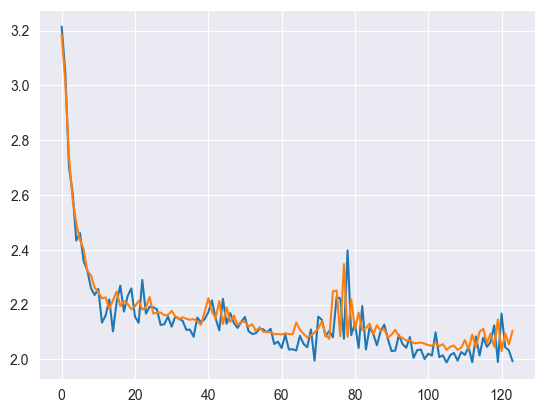

Batch 242
Training Loss = 2.1198, Training Acc = 0.2760
Validation Loss = 2.0337, Validation Acc = 0.3179



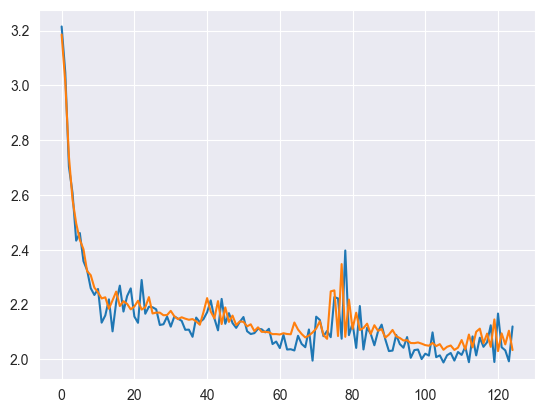

Batch 243
Training Loss = 2.0290, Training Acc = 0.3540
Validation Loss = 2.1149, Validation Acc = 0.2962



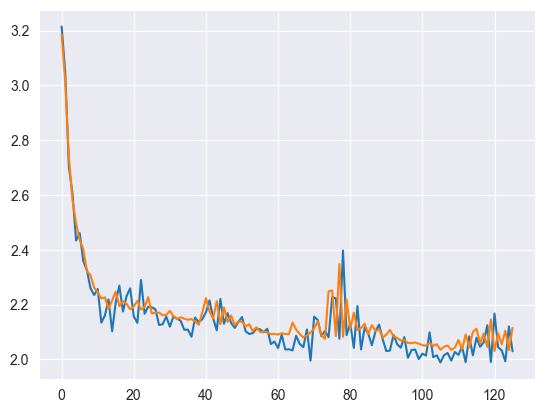

Batch 244
Training Loss = 2.1078, Training Acc = 0.2970
Validation Loss = 2.0612, Validation Acc = 0.3046



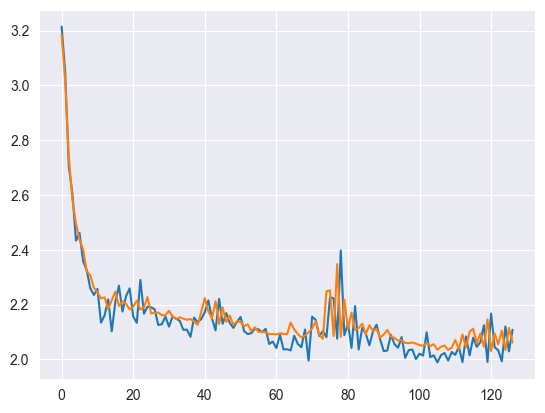

Batch 245
Training Loss = 2.0024, Training Acc = 0.3270
Validation Loss = 2.0905, Validation Acc = 0.2982



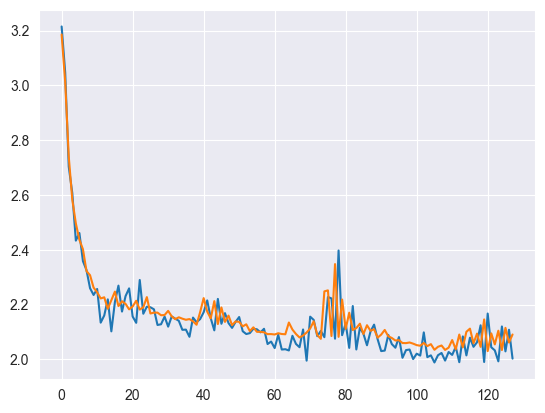

Batch 246
Training Loss = 2.0755, Training Acc = 0.3020
Validation Loss = 2.0363, Validation Acc = 0.3129



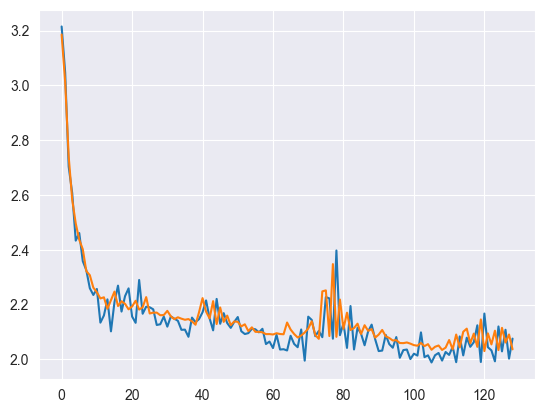

Batch 247
Training Loss = 1.9931, Training Acc = 0.3180
Validation Loss = 2.1161, Validation Acc = 0.2952



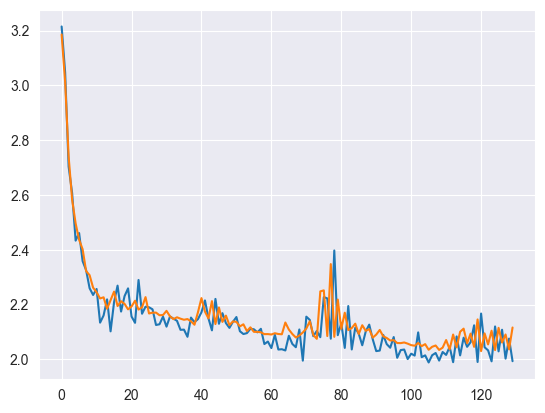

Batch 248
Training Loss = 2.1291, Training Acc = 0.2660
Validation Loss = 2.0191, Validation Acc = 0.3191



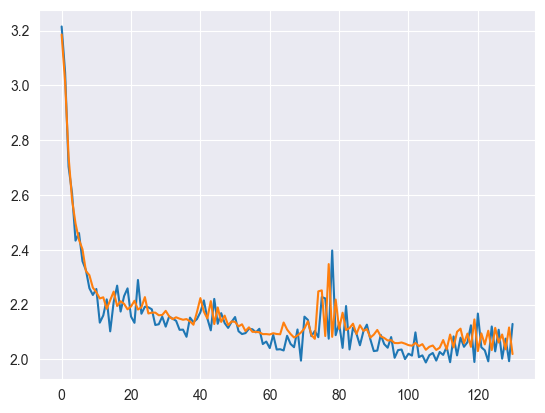

Batch 249
Training Loss = 1.9902, Training Acc = 0.3210
Validation Loss = 2.0886, Validation Acc = 0.2989



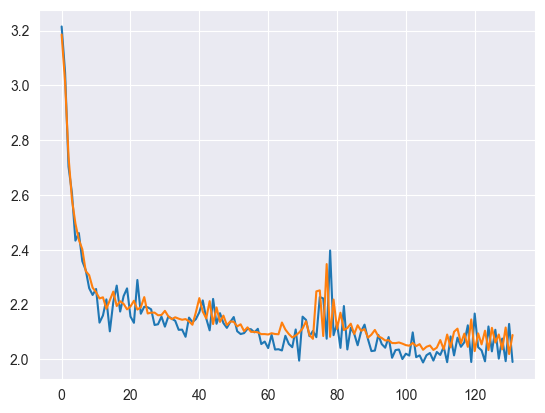

Batch 250
Training Loss = 2.0709, Training Acc = 0.3070
Validation Loss = 2.0291, Validation Acc = 0.3127



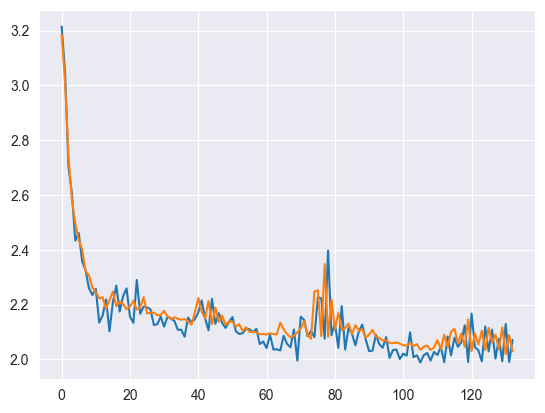

KeyboardInterrupt: 

In [10]:
from sklearn.metrics import f1_score

config = {
    "name": "benchmark"
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = GRUModel(
    num_venues=num_venues,
    num_actions=num_actions,
    num_trade=2,
    hidden_size=64,
    num_numeric=6,
    num_classes=24,
    seq_len=100
).to(device)

optimizer = optim.Adam(model.parameters(), lr=3e-3)  # default Optax-like parameters
criterion = nn.CrossEntropyLoss()

epochs = 10
num_batches_to_train = 129
batch_count = 0

history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

fig, ax = plt.subplots()
dh = display.display(fig, display_id=True)

while batch_count < epochs * num_batches_to_train:
    for (venues, actions, trades, numerics), labels in train_loader:
        model.train()

        venues   = venues.to(device)
        actions  = actions.to(device)
        trades   = trades.to(device)
        numerics = numerics.to(device)
        labels   = labels.to(device)
        
        # Forward
        logits = model(venues, actions, trades, numerics)  # shape (B, 24)
        
        loss = criterion(logits, labels)  # cross-entropy

        acc = (logits.argmax(dim=1) == labels).float().mean()
        
        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        batch_count += 1
        
        if batch_count % 12 == 0 or batch_count == 1 or batch_count >= num_batches_to_train:
            # validation
            model.eval()
            with torch.no_grad():
                val_accs = []
                val_losses = []
                for (v, a, t, n), l in val_loader:
                    v = v.to(device)
                    a = a.to(device)
                    t = t.to(device)
                    n = n.to(device)
                    l = l.to(device)
                    
                    logits = model(v, a, t, n)
                    val_acc = (logits.argmax(dim=1) == l).float().mean()
                    val_accs.append(val_acc)
                    val_loss = criterion(logits, l)
                    val_losses.append(val_loss)
                    # val_f1 = f1_score(l.cpu(), logits.argmax(dim=1).cpu(), average="macro")

                val_acc = torch.tensor(val_accs).mean()
                val_loss = torch.tensor(val_losses).mean()

            history["train_loss"].append(loss.item())
            history["train_acc"].append(acc.item())
            history["val_loss"].append(val_loss.item())
            history["val_acc"].append(val_acc.item())

            print(f"Batch {batch_count}\nTraining Loss = {loss.item():.4f}, Training Acc = {acc:.4f}\nValidation Loss = {val_loss:.4f}, Validation Acc = {val_acc:.4f}\n")

            ax.clear()
            ax.plot(history["train_loss"], label="train_loss")
            ax.plot(history["val_loss"], label="val_loss")
            dh.update(fig)

        if batch_count >= num_batches_to_train:
            break



# Save the model, history, and config
run_hash = abs(hash(str(model) + str(config) + str(history)))

torch.save(model.state_dict(), f"models/model_{run_hash}.pt")

with open(f"logs/history_{run_hash}.json", "w") as f:
    json.dump(history, f, indent=4)

with open(f"configs/config_{run_hash}.json", "w") as f:
    json.dump(config, f, indent=4)

print(f"Model, history, and config saved with hash: {run_hash}")

In [11]:
class StocksDatasetTest(Dataset):
    def __init__(self, df, seq_len=100):
        super().__init__()
        
        self.seq_len = seq_len
        
        # We group by obs_id
        # (You may need to ensure there's a 'time' or 'event_index' column to sort by.)
        grouped = df.groupby("obs_id")
        
        self.obs_ids = []
        self.X_groups = []
        
        for obs_id, group in grouped:
            # Sort by time index if needed (comment out if already sorted)
            # group = group.sort_values(by="time_or_event_index") 
            
            # Check we have exactly seq_len=100 rows
            if len(group) != seq_len:
                # Skip or handle carefully if your data occasionally doesn't have 100
                continue
            
            # Extract the 6 numeric fields
            # Make sure these columns are present in your CSV
            # and that trade is 0 or 1
            bid     = group["bid"].values
            ask     = group["ask"].values
            price   = group["price"].values
            bid_sz  = np.log(group["bid_size"].values + 1).clip(min=1e-10)  # guard against log(0)
            ask_sz  = np.log(group["ask_size"].values + 1).clip(min=1e-10)  # guard against log(0)
            flux    = np.log(group["flux"].values.clip(min=1e-10))  # guard against log(0)

            numeric_features = np.stack([bid, ask, price, bid_sz, ask_sz, flux], axis=-1)
            # shape = (100, 6)

            # Store the integer labels for the 3 embeddings
            venue  = group["venue"].values.astype(np.int64)
            action = group["action_cat"].values.astype(np.int64)
            trade  = group["trade"].values.astype(np.int64)
            # shape for each = (100,)


            self.obs_ids.append(obs_id)
            self.X_groups.append( (venue, action, trade, numeric_features) )

    def __len__(self):
        return len(self.X_groups)
    
    def __getitem__(self, idx):
        # Return the entire sequence of embeddings + numeric features + label
        venue, action, trade, numeric = self.X_groups[idx]
        return venue, action, trade, numeric
    
def stocks_collate_test_fn(batch):
    """
    batch is a list of ( (venue, action, trade, numeric), label ) of length = batch_size
    """
    venues = []
    actions = []
    trades = []
    numerics = []
    labels = []
    
    for venue, action, trade, numeric in batch:
        venues.append(venue)
        actions.append(action)
        trades.append(trade)
        numerics.append(numeric)
    
    # Convert to Torch tensors
    venues   = torch.LongTensor(venues)        # (batch_size, 100)
    actions  = torch.LongTensor(actions)       # (batch_size, 100)
    trades   = torch.LongTensor(trades)        # (batch_size, 100)
    numerics = torch.FloatTensor(numerics)     # (batch_size, 100, 6)
    
    return venues, actions, trades, numerics
    

test_dataset = StocksDatasetTest(test, seq_len=100)
test_loader = DataLoader(
    test_dataset,
    batch_size=1000,            
    shuffle=False,
    collate_fn=stocks_collate_test_fn
)

##### Benchmark Inference

In [12]:
from tqdm import tqdm


model.eval()
predictions = []

for venues, actions, trades, numerics in tqdm(test_loader):
    venues   = venues.to(device)
    actions  = actions.to(device)
    trades   = trades.to(device)
    numerics = numerics.to(device)
    
    logits = model(venues, actions, trades, numerics)
    predictions.append(logits.argmax(dim=1).cpu().numpy())


100%|██████████| 82/82 [00:15<00:00,  5.19it/s]


In [13]:
predictions = np.concatenate(predictions)

print(predictions.shape)

(81600,)


In [14]:
# submission = pd.merge(test[["obs_id"]], pd.DataFrame(predictions, columns=["eqt_code_cat"]), left_index=True, right_index=True)

# submission = submission.groupby("obs_id").eqt_code_cat.apply(lambda x: x.value_counts().sort_values(ascending=False).index[0])

submission = pd.DataFrame({
    "obs_id": test.obs_id.unique(),
    "eqt_code_cat": predictions
}).set_index("obs_id")

display(submission)

eqt_code_cat
obs_id              
0                  4
1                 15
2                 15
3                 15
4                 18
...              ...
81595             18
81596             18
81597             19
81598             18
81599             15

[81600 rows x 1 columns]

In [18]:
submission.to_csv(f"submissions/submission_{run_hash}.csv")

print(f"Submission saved with hash: {run_hash}")

Submission saved with hash: 1015930699909440695
